In [1]:
import json
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.stats
import pandas as pd
%matplotlib inline
plt.rcParams["figure.dpi"] = 150
BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
OUTPUT_PATH = "/Volumes/GoogleDrive/Meine Ablage/Dokumente/1 - Schule/1 - ETHZ/9. Semester/Master Thesis/thesis/img"

In [7]:
# Adapted from https://towardsdatascience.com/making-matplotlib-beautiful-by-default-d0d41e3534fd
sns.set(font='Helvetica',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': True,
 'axes.axisbelow': True,
 'grid.color': 'lightgrey',
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":14,
                                "axes.titlesize":16,
                                "axes.labelsize":13})

In [8]:
def parse_json(path):
    data = {}
    for f in os.listdir(path):
        lambda_no = 1
        has_multiple_lambda = False
        matches_multiple_lambda = re.search(r"(producer|consumer)_(\d+)_(\d+)_(\d+).json", f)
        if matches_multiple_lambda:
            lambda_no = int(matches_multiple_lambda.group(4))
            has_multiple_lambda = True
            matches = matches_multiple_lambda
        else:
            matches = re.search(r"(producer|consumer)_(\d+)_(\d+).json", f)
        if matches:
            run_type, file_size, run = matches.group(1), int(matches.group(2)), int(matches.group(3))
            if run_type not in data:
                data[run_type] = {}
            if file_size not in data[run_type]:
                data[run_type][file_size] = {}
            if has_multiple_lambda and run not in data[run_type][file_size]:
                data[run_type][file_size][run] = {}
            with open(os.path.join(path, f)) as file_p:
                json_data = json.load(file_p)
                if has_multiple_lambda:
                    data[run_type][file_size][run][lambda_no] = json_data
                else:
                    data[run_type][file_size][run] = json_data
    return data

In [9]:
def calc_deltas(data):
    deltas = {}
    for file_size, runs in data['consumer'].items():
        deltas[file_size] = {}
        for run_number, run_data in runs.items():
            if 'finishedTime' in run_data: # single lambda
                if int(np.log10(run_data['finishedTime'])) == 15:
                    # Convert to ms
                    run_data['finishedTime'] /= 1000
                    data['producer'][file_size][run_number]['uploadTime'] /= 1000
                if run_data['finishedTime'] - data['producer'][file_size][run_number]['uploadTime'] < 0.1:
                    deltas[file_size][run_number] = 0.1
                else:
                    deltas[file_size][run_number] = run_data['finishedTime'] - data['producer'][file_size][run_number]['uploadTime']
                
            else:
                all_finished_times = [lambda_run['finishedTime'] for lambda_run in run_data.values()]
                if int(np.log10(data['producer'][file_size][run_number]['uploadTime'])) == 15:
                    data['producer'][file_size][run_number]['uploadTime'] /= 1000
                    all_finished_times = [v / 1000 for v in all_finished_times]
                all_deltas = []
                for fin_time in all_finished_times:
                    if fin_time - data['producer'][file_size][run_number]['uploadTime'] < 0:
                        all_deltas.append(0.1)
                    else:
                        all_deltas.append(fin_time - data['producer'][file_size][run_number]['uploadTime'])

                deltas[file_size][run_number] = all_deltas
    return deltas

In [10]:
def format_xticks(label_values):
    xticks = []
    for val in label_values:
        if val == 10000:
            xticks.append("10⁴")
        elif val == 100000:
            xticks.append("10⁵")
        elif val == 500000:
            xticks.append("5·10⁵")
        elif val >= 1:
            xticks.append(str(int(val)))
        else:
            xticks.append(str(val))
    return xticks

# Experiments

In [11]:
experiments = {
    "S3": os.path.join(BASE_PATH, "s3"),
    "Redis": os.path.join(BASE_PATH, "redis"),
    "Direct": os.path.join(BASE_PATH, "nat")
}


## P2P

### Variance

(0.24865847826004028, 2.674668962085895e-20)
S3
222.2
(0.9526926875114441, 0.0012534911511465907)
Redis
13.5
(0.9268631339073181, 3.318036760902032e-05)
Direct
10.0
(0.7951151132583618, 1.7577431177251412e-10)
Direct (UDT)
2593.7


<ipython-input-116-f61ef496ba74>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


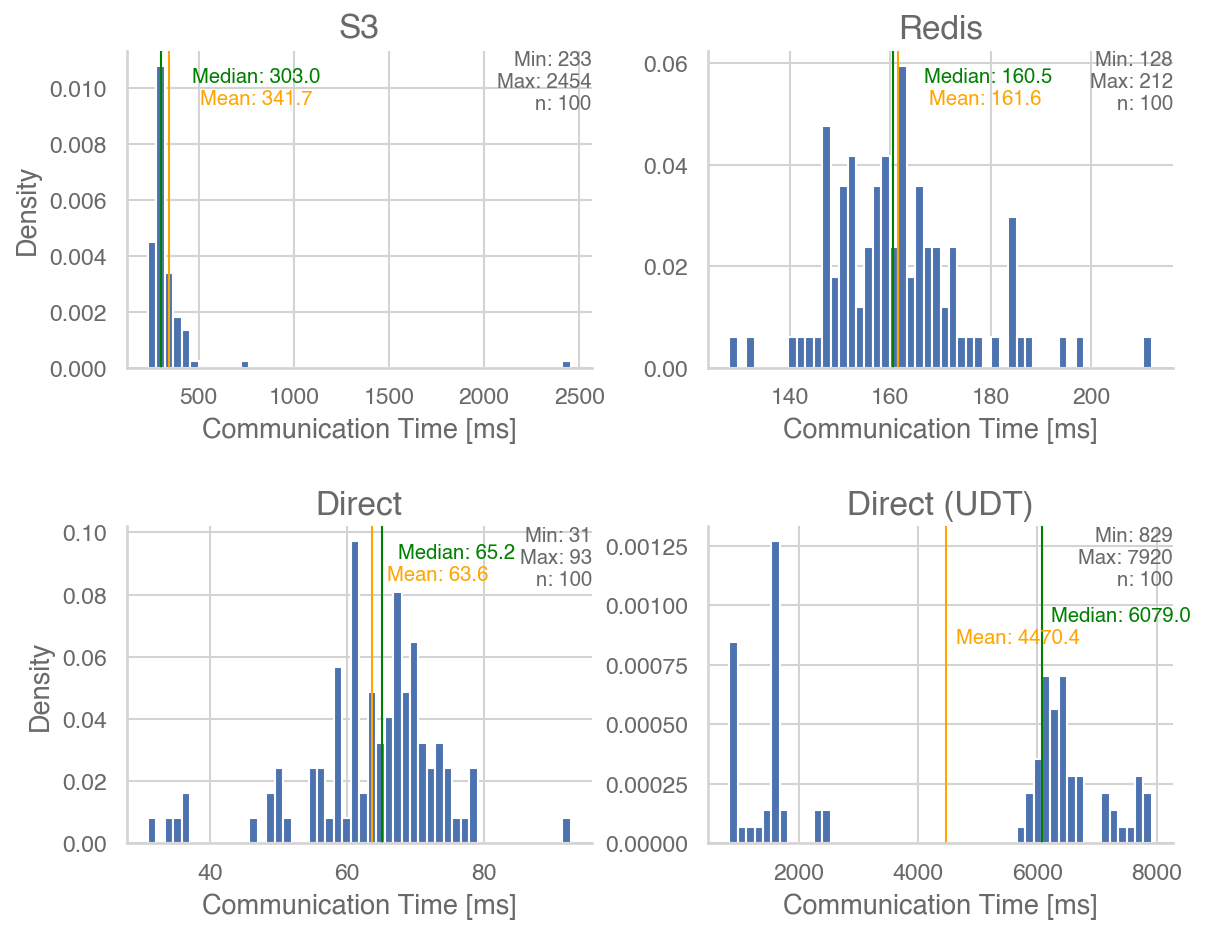

In [116]:
fig = plt.figure(figsize=(9,7))
gs = matplotlib.gridspec.GridSpec(2, 2, wspace=0.25, hspace=0.5) # 2x2 grid
axes = []
axes.append(fig.add_subplot(gs[0, 0]))
axes.append(fig.add_subplot(gs[0, 1]))
axes.append(fig.add_subplot(gs[1, 0]))
axes.append(fig.add_subplot(gs[1, 1]))
i = 0
exp_analysis = experiments.copy()
exp_analysis["Direct (UDT)"] = os.path.join(BASE_PATH, "nat")
for experiment_name, exp_base_path in exp_analysis.items():
    ax = axes[i]
    ax.set_title(experiment_name)
    var_base_path = os.path.join(exp_base_path, "p2p", "latency_distribution", "out")
    if experiment_name == "Direct (UDT)":
        var_base_path = os.path.join(exp_base_path, "p2p", "latency_distribution", "out_udt")
    res = parse_json(var_base_path)
    deltas = calc_deltas(res)
    delta_vals = list(deltas[10000000].values())
    print(scipy.stats.shapiro(delta_vals))
    mean = np.mean(delta_vals)
    var = np.var(delta_vals)
    std = np.std(delta_vals)
    print(experiment_name)
    print(round(std, 1))
    median = np.median(delta_vals)
    ax.hist(delta_vals, density=True, bins=50)
    ax.set_xlabel("Communication Time [ms]")
    if i == 0 or i ==2:
        ax.set_ylabel("Density")
    ax.axvline(mean, color='orange', linewidth=1)
    ax.axvline(median, color='green', linewidth=1)
    min_ylim, max_ylim = ax.get_ylim()
    min_xlim, max_xlim = ax.get_xlim()
    offset = (max_xlim - min_xlim) / 15
    y_offset_1 = 0.9
    y_offset_2 = 0.83
    if experiment_name == "Direct (UDT)":
        offset = (max_xlim - min_xlim) / 50
        y_offset_1 = 0.7
        y_offset_2 = 0.63
    if experiment_name == "Direct":
        offset = (max_xlim - min_xlim) / 30
    ax.text(median + offset, max_ylim*y_offset_1, 'Median: {:.1f}'.format(median), color="green", size="x-small")
    ax.text(mean + offset, max_ylim*y_offset_2, 'Mean: {:.1f}'.format(mean), color="orange", size="x-small")
    ax.text(max_xlim, max_ylim, 'Min: {:.0f}\nMax: {:.0f}\nn: {}'.format(np.min(delta_vals), np.max(delta_vals), len(delta_vals)), size='x-small', horizontalalignment='right', verticalalignment='top')
    i += 1
fig.show()
fig.savefig(os.path.join(OUTPUT_PATH, "p2p_variance.pdf"))

## 1 Byte Variance

<ipython-input-49-40b14c061a22>:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


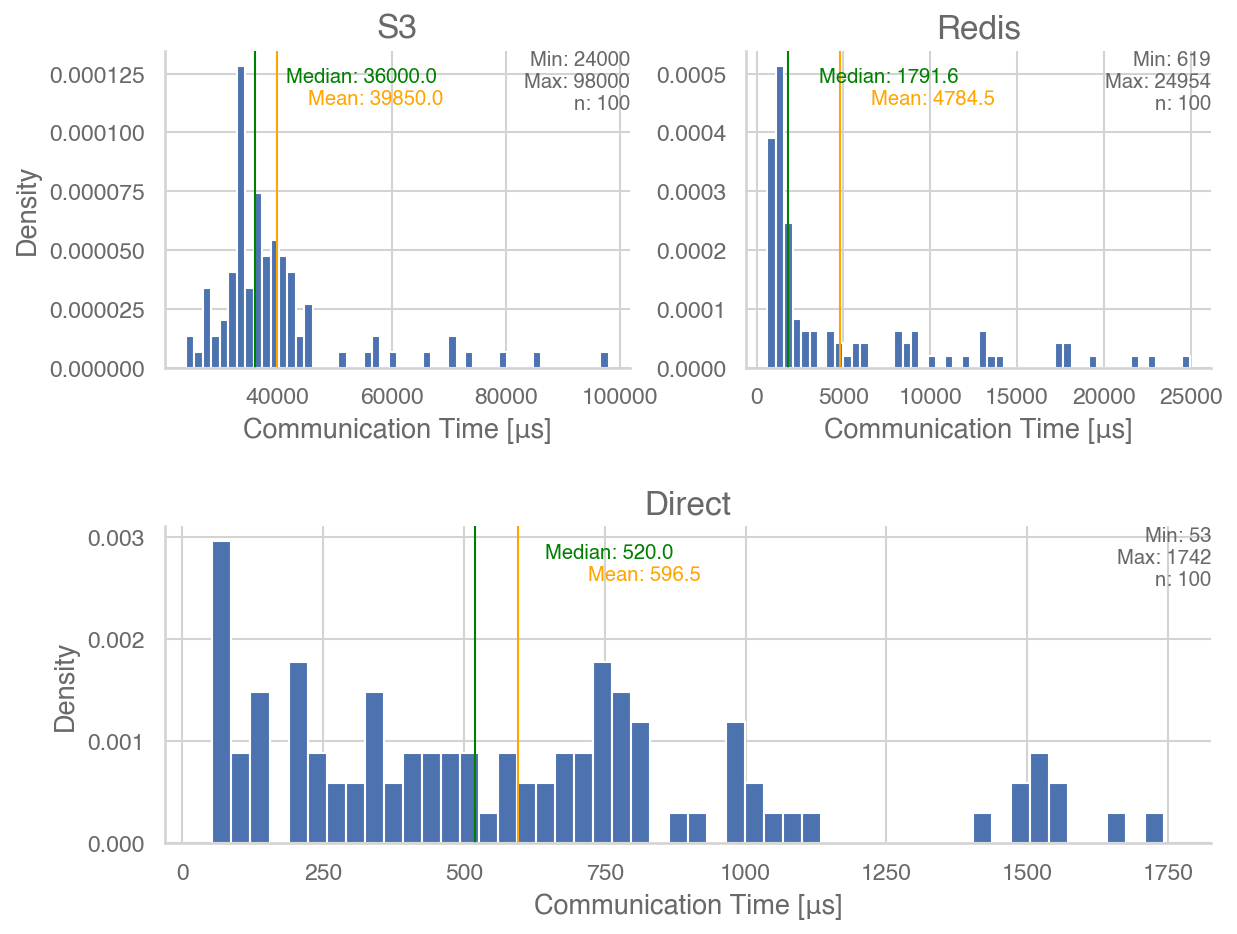

In [49]:
fig = plt.figure(figsize=(9,7))
gs = matplotlib.gridspec.GridSpec(2, 2, wspace=0.25, hspace=0.5) # 2x2 grid
axes = []
axes.append(fig.add_subplot(gs[0, 0]))
axes.append(fig.add_subplot(gs[0, 1]))
axes.append(fig.add_subplot(gs[1, :]))
i = 0
for experiment_name, exp_base_path in experiments.items():
    ax = axes[i]
    ax.set_title(experiment_name)
    var_base_path = os.path.join(exp_base_path, "p2p", "latency_distribution_1b", "out")
    res = parse_json(var_base_path)
    deltas = calc_deltas(res)
    delta_vals = [x * 1000 for x in list(deltas[1].values())]
    mean = np.mean(delta_vals)
    var = np.var(delta_vals)
    std = np.std(delta_vals)
    median = np.median(delta_vals)
    ax.hist(delta_vals, density=True, bins=50)
    ax.set_xlabel("Communication Time [μs]")
    if i == 0 or i ==2:
        ax.set_ylabel("Density")
    ax.axvline(mean, color='orange', linewidth=1)
    ax.axvline(median, color='green', linewidth=1)
    min_ylim, max_ylim = ax.get_ylim()
    min_xlim, max_xlim = ax.get_xlim()
    offset = (max_xlim - min_xlim) / 15
    y_offset_1 = 0.9
    y_offset_2 = 0.83
    #if experiment_name == "Direct":
        #offset = (max_xlim - min_xlim) / 30
    ax.text(median + offset, max_ylim*y_offset_1, 'Median: {:.1f}'.format(median), color="green", size="x-small")
    ax.text(mean + offset, max_ylim*y_offset_2, 'Mean: {:.1f}'.format(mean), color="orange", size="x-small")
    ax.text(max_xlim, max_ylim, 'Min: {:.0f}\nMax: {:.0f}\nn: {}'.format(np.min(delta_vals), np.max(delta_vals), len(delta_vals)), size='x-small', horizontalalignment='right', verticalalignment='top')
    i += 1
fig.show()
fig.savefig(os.path.join(OUTPUT_PATH, "p2p_variance_1b.pdf"))

### Performance

{0.001: 2.666666666666667e-05, 1.0: 0.02127659574468085, 10.0: 0.2564102564102564, 100.0: 2.197802197802198, 1000.0: 9.174311926605503, 10000.0: 37.17472118959108, 100000.0: 53.951982735365526}
{0.001: 0.0005, 1.0: 0.6666666666666666, 10.0: 4.0, 100.0: 8.333333333333334, 1000.0: 19.801980198019802, 10000.0: 52.35602094240838, 100000.0: 96.15384615384616}
{0.001: 0.0024541641701617736, 1.0: 10.0, 10.0: 31.905281196448048, 100.0: 63.17088217149908, 1000.0: 136.29481740287832, 10000.0: 171.67525881218828, 100000.0: 467.46544367846}
{0.001: 1.2870012870012869e-06, 1.0: 0.0014566642388929353, 10.0: 0.018957345971563982, 100.0: 0.05124263387138099, 1000.0: 0.191131498470948, 10000.0: 1.8501387604070305, 100000.0: 11.83361931246672}


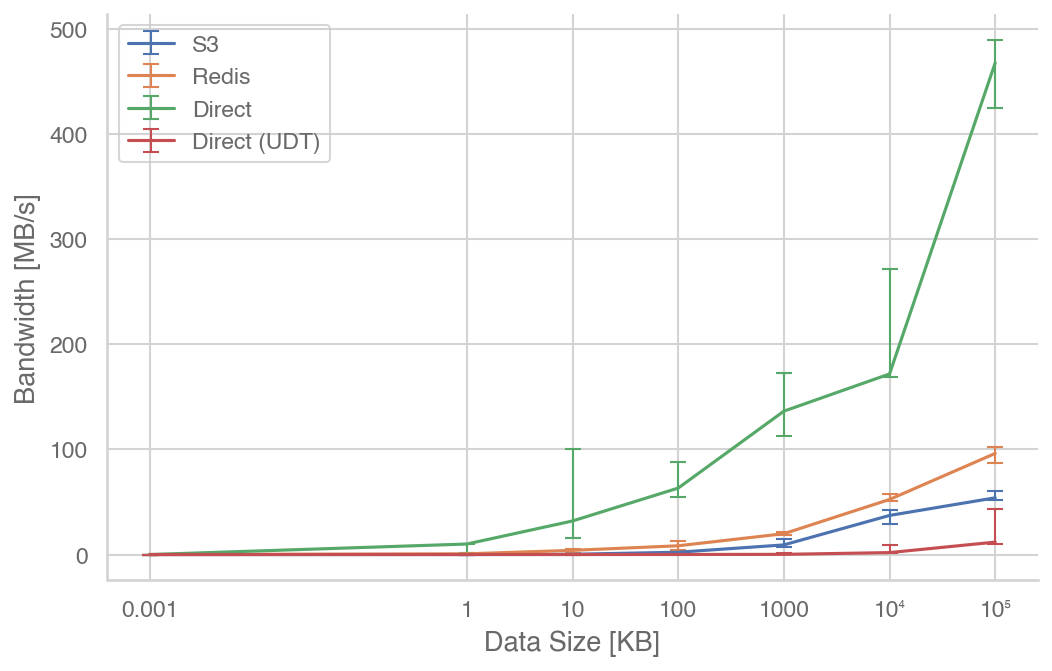

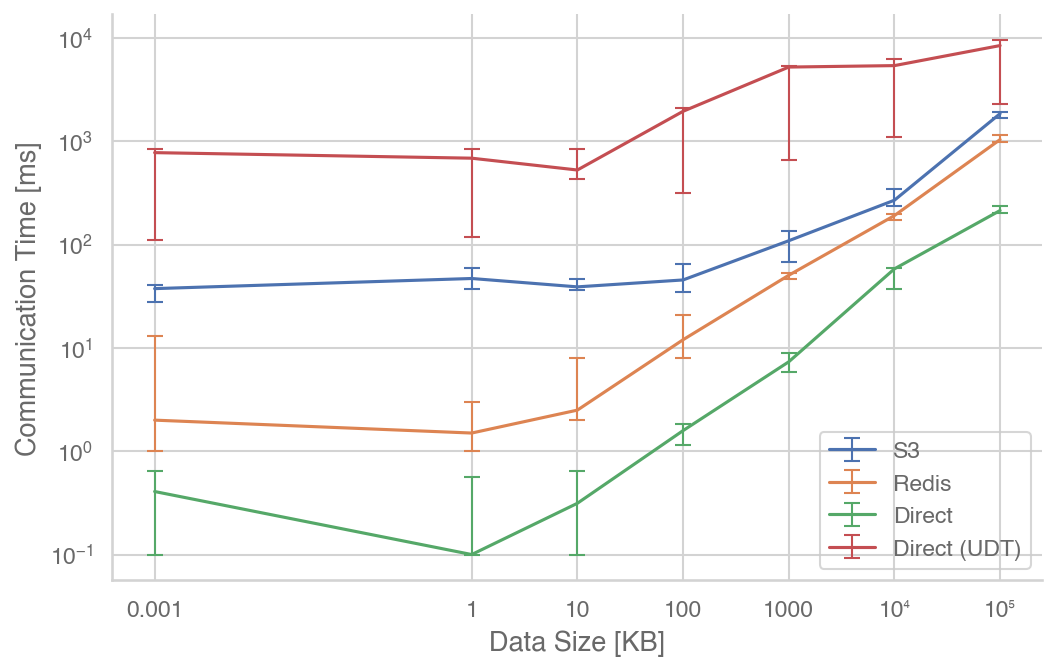

In [123]:
p2p_experiment_means = {}
p2p_experiment_cis = {}
fig, fig2 = plt.figure(figsize=(8,5)), plt.figure(figsize=(8,5))
ax, ax2 = fig.add_subplot(), fig2.add_subplot()
exp_analysis = experiments.copy()
exp_analysis["Direct (UDT)"] = os.path.join(BASE_PATH, "nat")
for experiment_name, exp_base_path in exp_analysis.items():
    p2p_experiment_means[experiment_name] = {}
    p2p_experiment_cis[experiment_name] = {}
    var_base_path = os.path.join(exp_base_path, "p2p", "scaling", "out")
    if experiment_name == "Direct (UDT)":
        var_base_path = os.path.join(exp_base_path, "p2p", "scaling", "out_udt")
    res = parse_json(var_base_path)
    deltas = calc_deltas(res)
    plot_data = {}
    lower_error = []
    upper_error = []
    for file_size in sorted(deltas):
        if file_size == 500000000:
            continue
        values = list(deltas[file_size].values())
        val = file_size / np.median(values) / 1000
        mean = np.mean(values)
        ci = scipy.stats.sem(values) * scipy.stats.t.ppf((1 + 0.95) / 2., len(values) - 1)
        p2p_experiment_means[experiment_name][file_size / 1000] = mean
        p2p_experiment_cis[experiment_name][file_size / 1000] = ci
        plot_data[file_size / 1000] = val
        upper_ci = file_size / np.sort(values)[1] / 1000 - val
        lower_ci = val - file_size / np.sort(values)[-2] / 1000
        lower_error.append(lower_ci)
        upper_error.append(upper_ci)
    print(plot_data)
    ax.set_xscale('log')
    ax.set_xlabel("Data Size [KB]")
    ax.set_xticks(list(plot_data.keys()))
    ax.set_xticklabels(format_xticks(plot_data.keys()))
    ax.set_ylabel("Bandwidth [MB/s]")
    ax.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], elinewidth=1, capsize=4, label=experiment_name)

    plot_data = {}
    lower_error = []
    upper_error = []
    for file_size in sorted(deltas):
        if file_size == 500000000:
            continue
        values = list(deltas[file_size].values())
        val = np.median(values)
        plot_data[file_size / 1000] = val
        upper_ci = np.sort(values)[-2] - val
        lower_ci = val - np.sort(values)[1]
        lower_error.append(lower_ci)
        upper_error.append(upper_ci)
    ax2.set_xscale('log')
    ax2.set_xlabel("Data Size [KB]")
    ax2.set_xticks(list(plot_data.keys()))
    ax2.set_xticklabels(format_xticks(plot_data.keys()))
    ax2.set_ylabel("Communication Time [ms]")
    ax2.set_yscale('log')
    ax2.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], elinewidth=1, capsize=4, label=experiment_name)



ax.legend()
ax2.legend()
fig.savefig(os.path.join(OUTPUT_PATH, "p2p_bandwidth.pdf"), bbox_inches='tight')
fig2.savefig(os.path.join(OUTPUT_PATH, "p2p_latency.pdf"), bbox_inches='tight')
plt.show()


#### Without UDT

{0.001: 2.666666666666667e-05, 1.0: 0.02127659574468085, 10.0: 0.2564102564102564, 100.0: 2.197802197802198, 1000.0: 9.174311926605503, 10000.0: 37.17472118959108, 100000.0: 53.951982735365526}
{0.001: 0.0005, 1.0: 0.6666666666666666, 10.0: 4.0, 100.0: 8.333333333333334, 1000.0: 19.801980198019802, 10000.0: 52.35602094240838, 100000.0: 96.15384615384616}
{0.001: 0.0024541641701617736, 1.0: 10.0, 10.0: 31.905281196448048, 100.0: 63.17088217149908, 1000.0: 136.29481740287832, 10000.0: 171.67525881218828, 100000.0: 467.46544367846}
/Users/roman/CPPProjects/lambda_comm_benchmarks/analysis


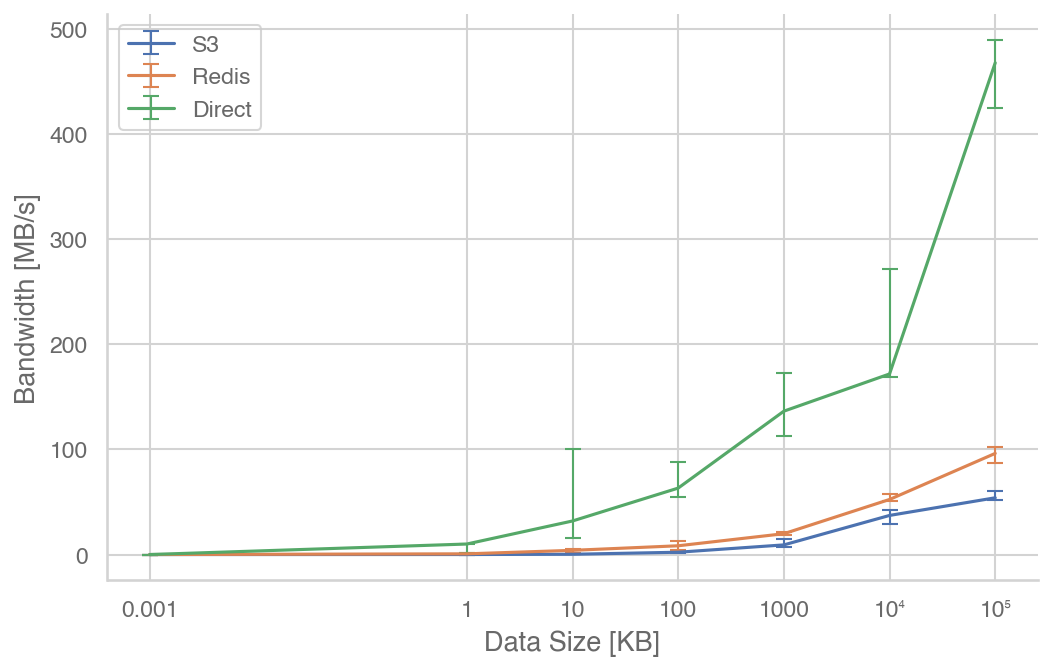

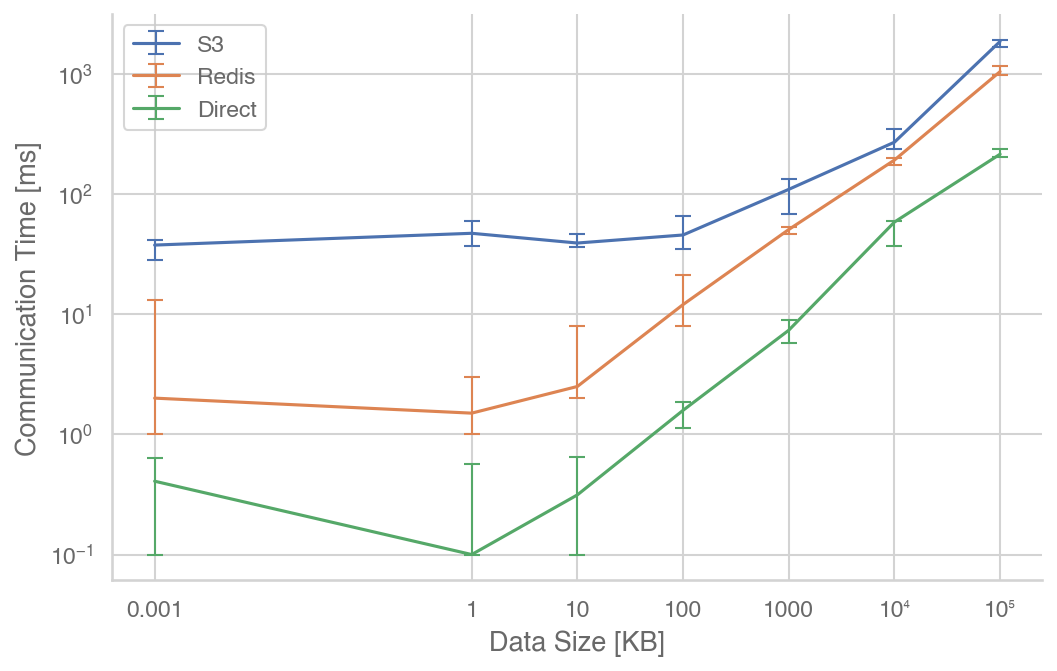

In [17]:
p2p_experiment_means = {}
p2p_experiment_cis = {}
fig, fig2 = plt.figure(figsize=(8,5)), plt.figure(figsize=(8,5))
ax, ax2 = fig.add_subplot(), fig2.add_subplot()
for experiment_name, exp_base_path in experiments.items():
    p2p_experiment_means[experiment_name] = {}
    p2p_experiment_cis[experiment_name] = {}
    var_base_path = os.path.join(exp_base_path, "p2p", "scaling", "out")
    if experiment_name == "Direct (UDT)":
        var_base_path = os.path.join(exp_base_path, "p2p", "scaling", "out_udt")
    res = parse_json(var_base_path)
    deltas = calc_deltas(res)
    plot_data = {}
    lower_error = []
    upper_error = []
    for file_size in sorted(deltas):
        if file_size == 500000000:
            continue
        values = list(deltas[file_size].values())
        val = file_size / np.median(values) / 1000
        mean = np.mean(values)
        ci = scipy.stats.sem(values) * scipy.stats.t.ppf((1 + 0.95) / 2., len(values) - 1)
        p2p_experiment_means[experiment_name][file_size / 1000] = mean
        p2p_experiment_cis[experiment_name][file_size / 1000] = ci
        plot_data[file_size / 1000] = val
        upper_ci = file_size / np.sort(values)[1] / 1000 - val
        lower_ci = val - file_size / np.sort(values)[-2] / 1000
        lower_error.append(lower_ci)
        upper_error.append(upper_ci)
    print(plot_data)
    ax.set_xscale('log')
    ax.set_xlabel("Data Size [KB]")
    ax.set_xticks(list(plot_data.keys()))
    ax.set_xticklabels(format_xticks(plot_data.keys()))
    ax.set_ylabel("Bandwidth [MB/s]")
    ax.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], elinewidth=1, capsize=4, label=experiment_name)

    plot_data = {}
    lower_error = []
    upper_error = []
    for file_size in sorted(deltas):
        if file_size == 500000000:
            continue
        values = list(deltas[file_size].values())
        val = np.median(values)
        plot_data[file_size / 1000] = val
        upper_ci = np.sort(values)[-2] - val
        lower_ci = val - np.sort(values)[1]
        lower_error.append(lower_ci)
        upper_error.append(upper_ci)
    ax2.set_xscale('log')
    ax2.set_xlabel("Data Size [KB]")
    ax2.set_xticks(list(plot_data.keys()))
    ax2.set_xticklabels(format_xticks(plot_data.keys()))
    ax2.set_ylabel("Communication Time [ms]")
    ax2.set_yscale('log')
    ax2.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], elinewidth=1, capsize=4, label=experiment_name)



ax.legend()
ax2.legend()
print(os.getcwd())
fig.savefig(os.path.join(os.getcwd(), "img_paper", "p2p_bandwidth.pdf"), bbox_inches='tight')
fig2.savefig(os.path.join(os.getcwd(), "img_paper", "p2p_latency.pdf"), bbox_inches='tight')
plt.show()


{0.001: 0.0024541641701617736, 1.0: 10.0, 10.0: 31.905281196448048, 100.0: 63.17088217149908, 1000.0: 136.29481740287832, 10000.0: 171.67525881218828, 100000.0: 467.46544367846}


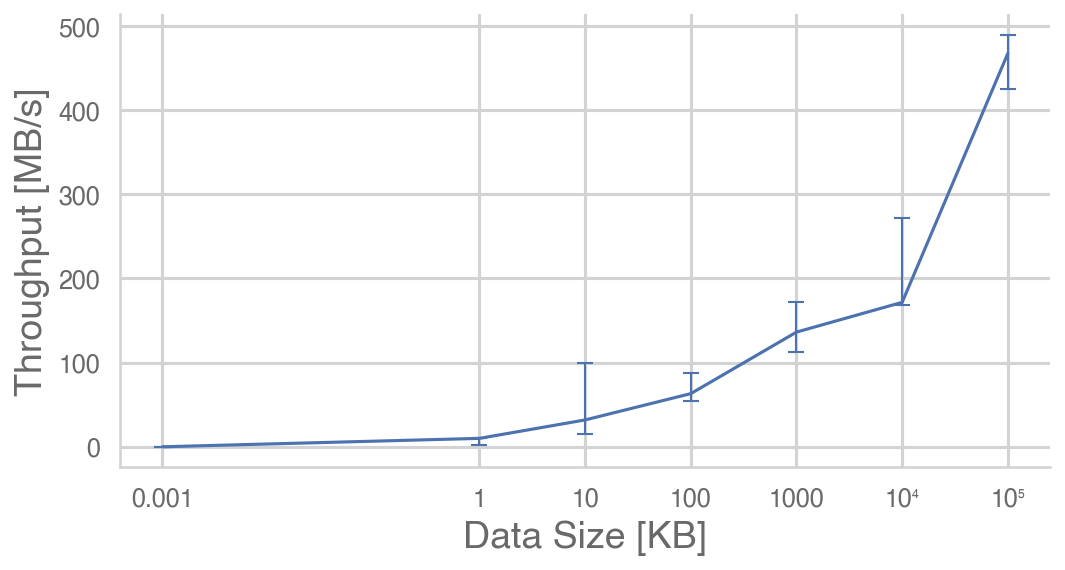

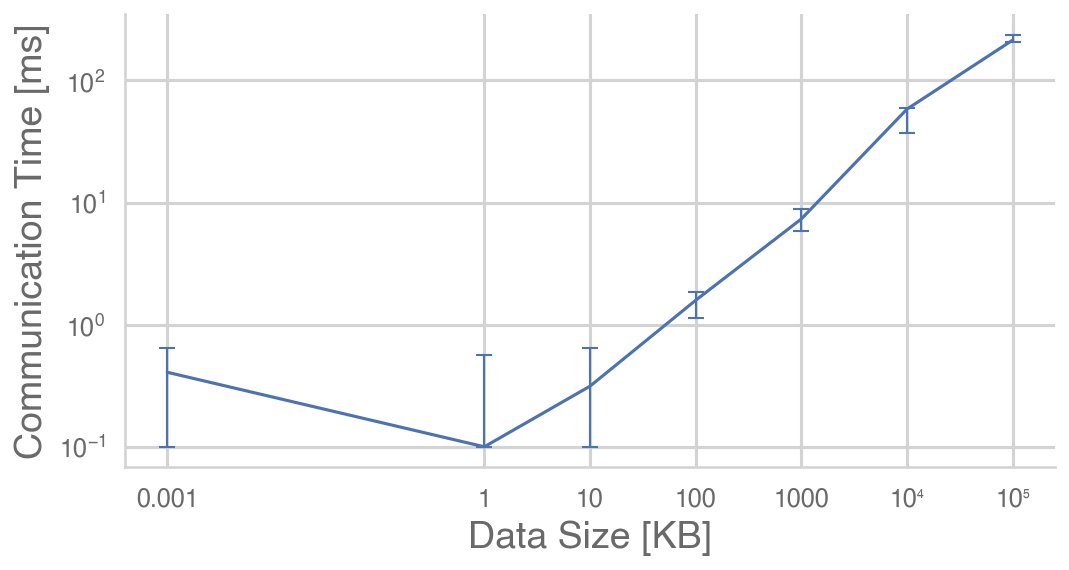

In [118]:
p2p_experiment_means = {}
p2p_experiment_cis = {}
fig, fig2 = plt.figure(figsize=(8,4)), plt.figure(figsize=(8,4))
ax, ax2 = fig.add_subplot(), fig2.add_subplot()
axis_items = [ax.xaxis.label, ax.yaxis.label, ax2.xaxis.label, ax2.yaxis.label]
[it.set_fontsize(18) for it in axis_items]
labels = ax.get_xticklabels() + ax.get_yticklabels() + ax2.get_xticklabels() + ax2.get_yticklabels()
[it.set_fontsize(12) for it in labels]
experiment_name = "Direct Communication"
exp_base_path = os.path.join(BASE_PATH, "nat")
var_base_path = os.path.join(exp_base_path, "p2p", "scaling", "out")
res = parse_json(var_base_path)
deltas = calc_deltas(res)
plot_data = {}
lower_error = []
upper_error = []
for file_size in sorted(deltas):
    if file_size == 500000000:
        continue
    values = list(deltas[file_size].values())
    val = file_size / np.median(values) / 1000
    mean = np.mean(values)
    ci = scipy.stats.sem(values) * scipy.stats.t.ppf((1 + 0.95) / 2., len(values) - 1)
    plot_data[file_size / 1000] = val
    upper_ci = file_size / np.sort(values)[1] / 1000 - val
    lower_ci = val - file_size / np.sort(values)[-2] / 1000
    lower_error.append(lower_ci)
    upper_error.append(upper_ci)
print(plot_data)
ax.set_xscale('log')
ax.set_xlabel("Data Size [KB]", fontweight='bold')
ax.set_xticks(list(plot_data.keys()))
ax.set_xticklabels(format_xticks(plot_data.keys()))
ax.set_ylabel("Throughput [MB/s]", fontweight='bold')
ax.grid(b=True, which='major', linestyle='-', linewidth=1.5)
ax.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], elinewidth=1, capsize=4, label=experiment_name)

plot_data = {}
lower_error = []
upper_error = []
for file_size in sorted(deltas):
    if file_size == 500000000:
        continue
    values = list(deltas[file_size].values())
    val = np.median(values)
    plot_data[file_size / 1000] = val
    upper_ci = np.sort(values)[-2] - val
    lower_ci = val - np.sort(values)[1]
    lower_error.append(lower_ci)
    upper_error.append(upper_ci)
ax2.set_xscale('log')
ax2.set_xlabel("Data Size [KB]", fontweight='bold')
ax2.set_xticks(list(plot_data.keys()))
ax2.set_xticklabels(format_xticks(plot_data.keys()))
ax2.set_ylabel("Communication Time [ms]", fontweight='bold')
ax2.set_yscale('log')
ax2.grid(b=True, which='major', linestyle='-', linewidth=1.5)
ax2.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], elinewidth=1, capsize=4, label=experiment_name)



#ax.legend()
#ax2.legend()
fig.savefig("/Users/roman/Downloads/p2p_bandwidth.pdf", bbox_inches='tight')
fig2.savefig("/Users/roman/Downloads/p2p_latency.pdf", bbox_inches='tight')
plt.show()

## Download-Only

S3
{0.001: 10.3025, 1.0: 13.682500000000001, 10.0: 12.4825, 100.0: 15.024999999999999, 1000.0: 20.4135, 10000.0: 102.43700000000001, 100000.0: 1002.3795}
Redis (t3.small)
{0.001: 0.947, 1.0: 0.97, 10.0: 1.108, 100.0: 4.743, 1000.0: 24.595, 10000.0: 84.562, 100000.0: 526.2665}
Redis (t3.medium)
{0.001: 1.014, 1.0: 1.0485, 10.0: 1.0405, 100.0: 5.0435, 1000.0: 21.5825, 10000.0: 84.07900000000001, 100000.0: 462.505}


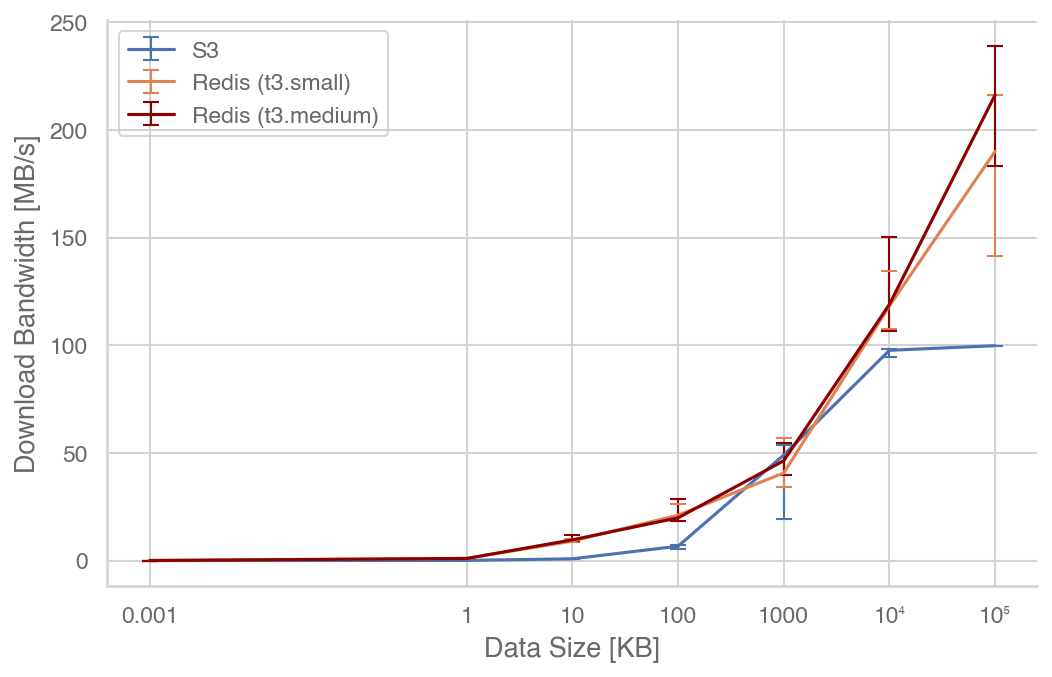

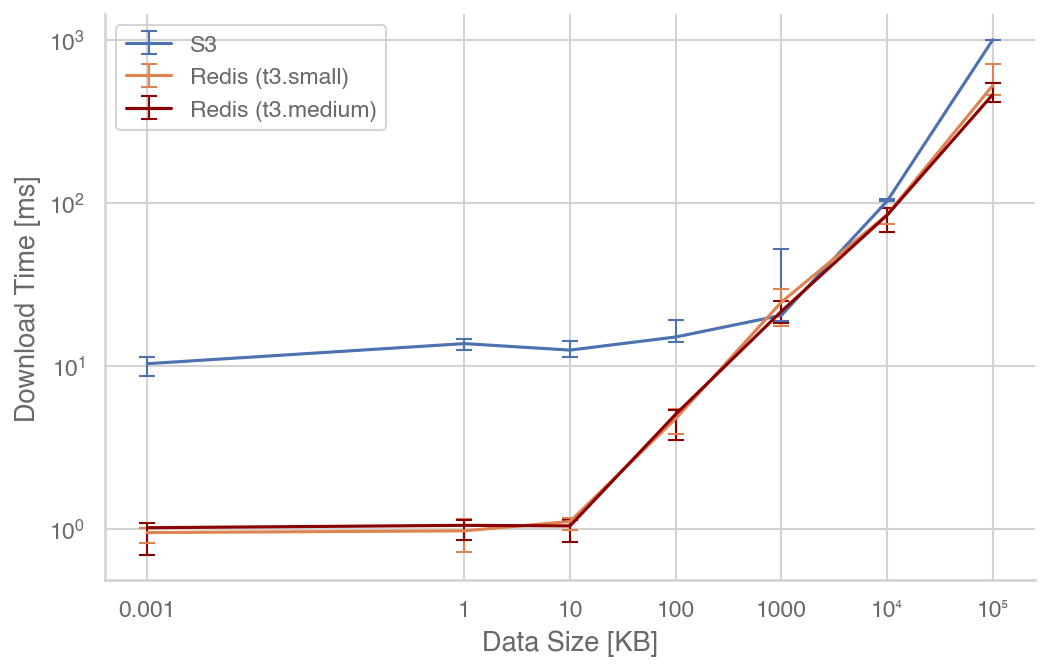

In [24]:
fig, fig2 = plt.figure(figsize=(8,5)), plt.figure(figsize=(8,5))
ax, ax2 = fig.add_subplot(), fig2.add_subplot()
exp_analysis = {
    "S3": os.path.join(BASE_PATH, "s3"),
    "Redis (t3.small)": os.path.join(BASE_PATH, "redis"),
    "Redis (t3.medium)": os.path.join(BASE_PATH, "redis")
}
for experiment_name, exp_base_path in exp_analysis.items():
    print(experiment_name)
    var_base_path = os.path.join(exp_base_path, "download", "out")
    if experiment_name == "Redis (t3.small)":
        var_base_path = os.path.join(exp_base_path, "download", "out_small")
    elif experiment_name == "Redis (t3.medium)":
        var_base_path = os.path.join(exp_base_path, "download", "out_medium")
    res = parse_json(var_base_path)
    deltas = {}
    for file_size, runs in res['consumer'].items():
        deltas[file_size] = {}
        for run, run_data in runs.items():
            deltas[file_size][run] = run_data['finishedTime'] / 1000
    plot_data = {}
    lower_error = []
    upper_error = []
    for file_size in sorted(deltas):
        values = list(deltas[file_size].values())
        val = file_size / np.median(values) / 1000
        mean = np.mean(values)
        ci = scipy.stats.sem(values) * scipy.stats.t.ppf((1 + 0.95) / 2., len(values) - 1)
        plot_data[file_size / 1000] = val
        upper_ci = file_size / np.sort(values)[1] / 1000 - val
        lower_ci = val - file_size / np.sort(values)[-2] / 1000
        lower_error.append(lower_ci)
        upper_error.append(upper_ci)
    ax.set_xscale('log')
    ax.set_xlabel("Data Size [KB]")
    ax.set_xticks(list(plot_data.keys()))
    ax.set_xticklabels(format_xticks(plot_data.keys()))
    ax.set_ylabel("Download Bandwidth [MB/s]")
    if experiment_name == "Redis (t3.medium)":
        ax.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], elinewidth=1, capsize=4, label=experiment_name, color='darkred')
    else:
        ax.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], elinewidth=1, capsize=4, label=experiment_name)

    plot_data = {}
    lower_error = []
    upper_error = []
    for file_size in sorted(deltas):
        if file_size == 500000000:
            continue
        values = list(deltas[file_size].values())
        val = np.median(values)
        plot_data[file_size / 1000] = val
        upper_ci = np.sort(values)[-2] - val
        lower_ci = val - np.sort(values)[1]
        lower_error.append(lower_ci)
        upper_error.append(upper_ci)
    print(plot_data)
    ax2.set_xscale('log')
    ax2.set_xlabel("Data Size [KB]")
    ax2.set_xticks(list(plot_data.keys()))
    ax2.set_xticklabels(format_xticks(plot_data.keys()))
    ax2.set_ylabel("Download Time [ms]")
    ax2.set_yscale('log')
    if experiment_name == "Redis (t3.medium)":
        ax2.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], elinewidth=1, capsize=4, label=experiment_name, color='darkred')
    else:
        ax2.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], elinewidth=1, capsize=4, label=experiment_name)



ax.legend()
ax2.legend()
fig.savefig(os.path.join(OUTPUT_PATH, "p2p_dl_bandwidth.pdf"), bbox_inches='tight')
fig2.savefig(os.path.join(OUTPUT_PATH, "p2p_dl_latency.pdf"), bbox_inches='tight')
plt.show()


## Lambda RAM

{0.001: 0.0024541641701617736, 1.0: 10.0, 10.0: 31.905281196448048, 100.0: 63.17088217149908, 1000.0: 136.29481740287832, 10000.0: 171.67525881218828, 100000.0: 467.46544367846}
{0.001: 0.0018184239733629302, 1.0: 2.739799331103679, 10.0: 17.953101030024108, 100.0: 29.29585523727783, 1000.0: 50.16810479450796, 10000.0: 150.19783137213201, 100000.0: 439.27453210452285}
{0.001: 0.003484474691620587, 1.0: 1.6876802637000412, 10.0: 41.66836215666328, 100.0: 47.88123210006429, 1000.0: 74.81688494346722, 10000.0: 189.68495440799862, 100000.0: 295.0234952793359}
{0.001: 0.0013342019543973942, 1.0: 1.4024995719910973, 10.0: 13.965223320831912, 100.0: 32.15449228716097, 1000.0: 51.74493888766067, 10000.0: 101.31140891124863, 100000.0: 165.49575189859507}


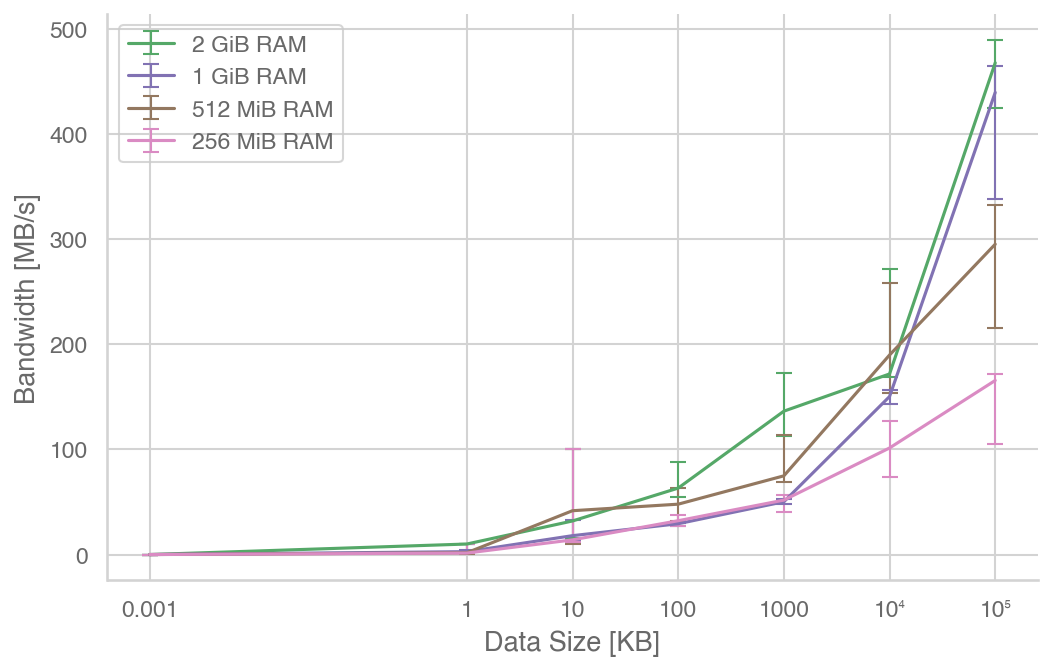

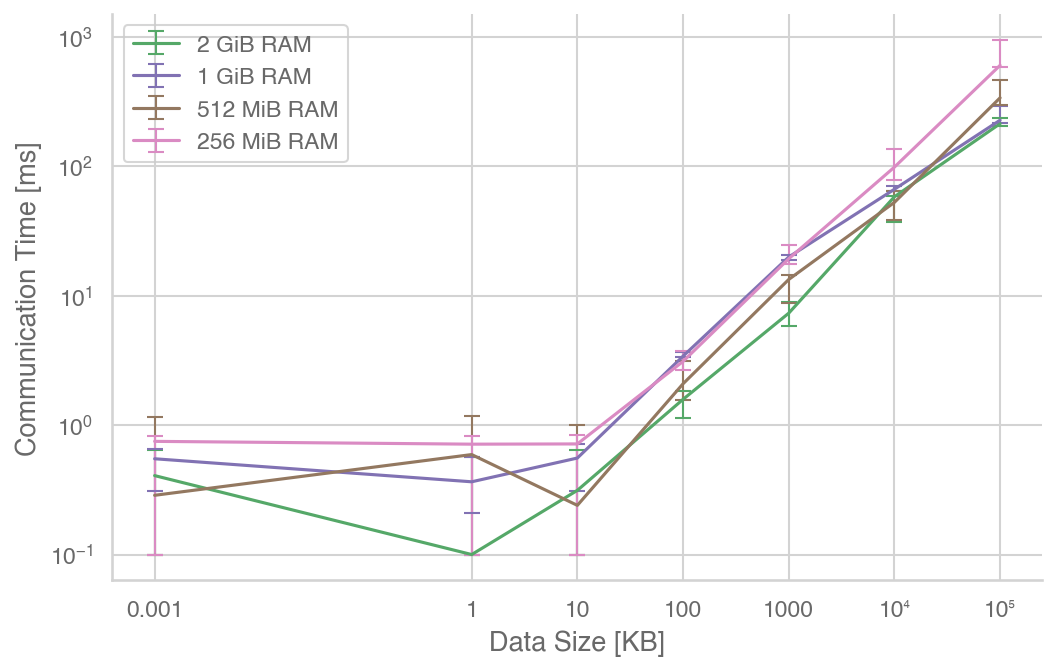

In [11]:
fig, fig2 = plt.figure(figsize=(8,5)), plt.figure(figsize=(8,5))
ax, ax2 = fig.add_subplot(), fig2.add_subplot()
exp_analysis = {
    "2 GiB RAM": os.path.join(BASE_PATH, "nat", "p2p", "scaling", "out"),
    "1 GiB RAM": os.path.join(BASE_PATH, "nat", "p2p", "scaling", "out_1024ram"),
    "512 MiB RAM": os.path.join(BASE_PATH, "nat", "p2p", "scaling", "out_512ram"),
    "256 MiB RAM": os.path.join(BASE_PATH, "nat", "p2p", "scaling", "out_256ram")
}
for experiment_name, exp_base_path in exp_analysis.items():
    var_base_path = exp_base_path
    res = parse_json(var_base_path)
    deltas = calc_deltas(res)
    plot_data = {}
    lower_error = []
    upper_error = []
    for file_size in sorted(deltas):
        if file_size == 500000000:
            continue
        values = list(deltas[file_size].values())
        val = file_size / np.median(values) / 1000
        mean = np.mean(values)
        ci = scipy.stats.sem(values) * scipy.stats.t.ppf((1 + 0.95) / 2., len(values) - 1)
        plot_data[file_size / 1000] = val
        upper_ci = file_size / np.sort(values)[1] / 1000 - val
        lower_ci = val - file_size / np.sort(values)[-2] / 1000
        lower_error.append(lower_ci)
        upper_error.append(upper_ci)
    print(plot_data)
    ax.set_xscale('log')
    ax.set_xlabel("Data Size [KB]")
    ax.set_xticks(list(plot_data.keys()))
    ax.set_xticklabels(format_xticks(plot_data.keys()))
    ax.set_ylabel("Bandwidth [MB/s]")
    color = None
    if experiment_name == "2 GiB RAM":
        color = 'C2'
    elif experiment_name == "1 GiB RAM":
        color = 'C4'
    elif experiment_name == "512 MiB RAM":
        color = 'C5'
    elif experiment_name == "256 MiB RAM":
        color = 'C6'
        
    ax.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], elinewidth=1, capsize=4, label=experiment_name, color=color)

    plot_data = {}
    lower_error = []
    upper_error = []
    for file_size in sorted(deltas):
        if file_size == 500000000:
            continue
        values = list(deltas[file_size].values())
        val = np.median(values)
        plot_data[file_size / 1000] = val
        upper_ci = np.sort(values)[-2] - val
        lower_ci = val - np.sort(values)[1]
        lower_error.append(lower_ci)
        upper_error.append(upper_ci)
    ax2.set_xscale('log')
    ax2.set_xlabel("Data Size [KB]")
    ax2.set_xticks(list(plot_data.keys()))
    ax2.set_xticklabels(format_xticks(plot_data.keys()))
    ax2.set_ylabel("Communication Time [ms]")
    ax2.set_yscale('log')
    ax2.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], elinewidth=1, capsize=4, label=experiment_name, color=color)



ax.legend()
ax2.legend()
fig.savefig(os.path.join(OUTPUT_PATH, "p2p_dl_bandwidth_direct.pdf"), bbox_inches='tight')
fig2.savefig(os.path.join(OUTPUT_PATH, "p2p_dl_latency_direct.pdf"), bbox_inches='tight')
plt.show()

## One to Many

### Variance

63.7
66.6
62.2


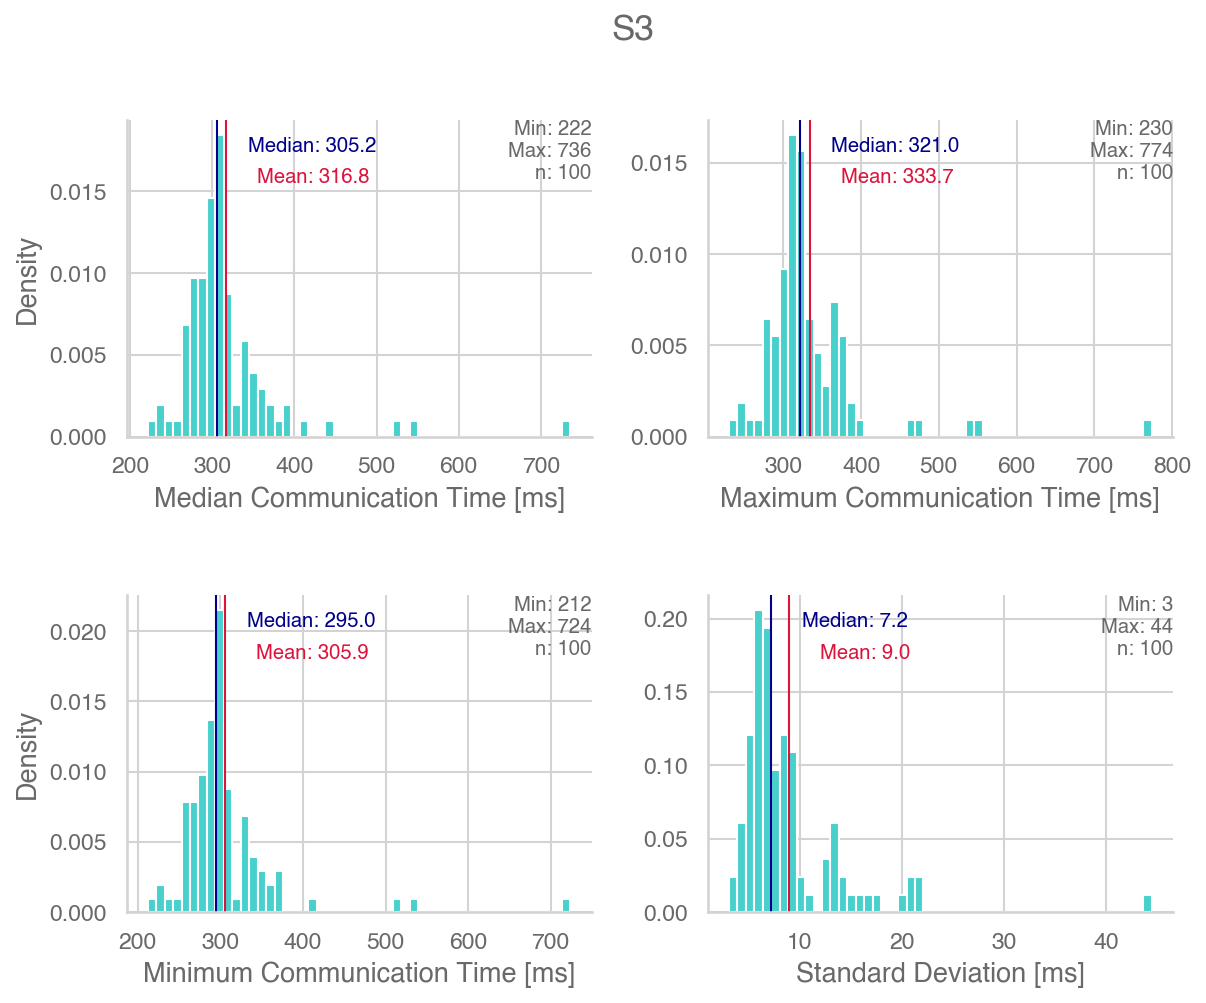

25.1
60.8
25.1


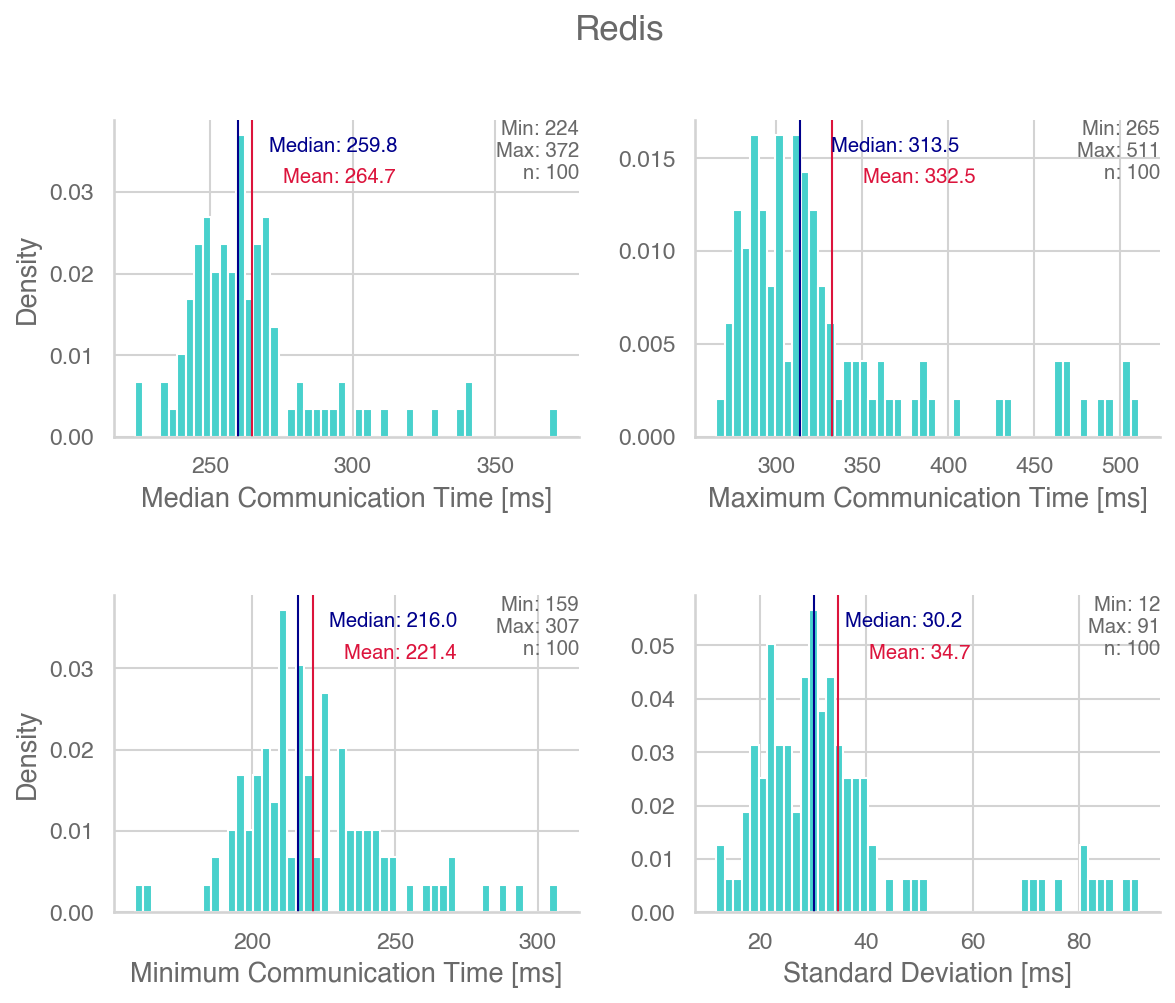

26.6
35.4
15.3


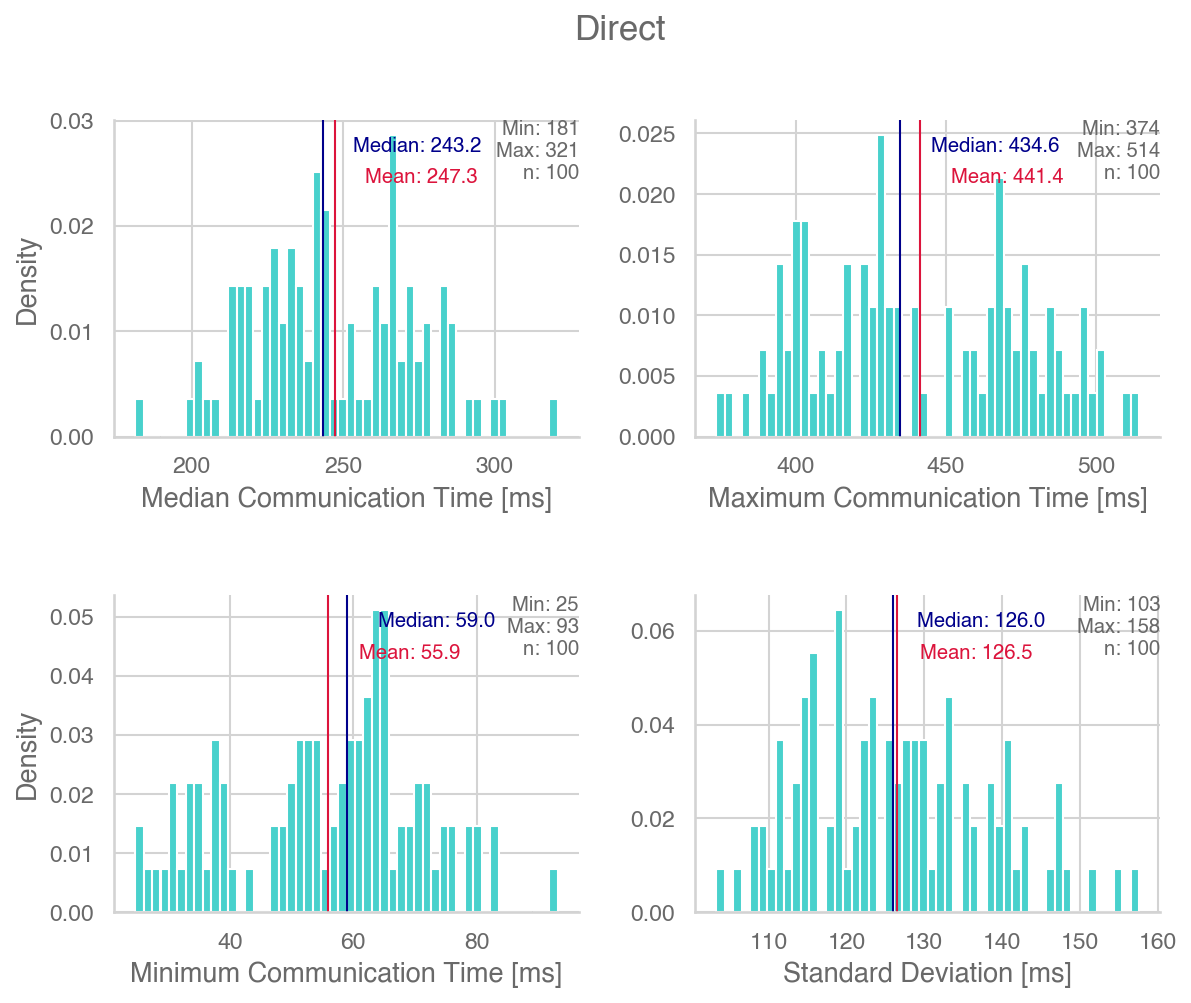

In [119]:
for experiment_name, exp_base_path in experiments.items():
    fig = plt.figure(figsize=(9,7))
    fig.suptitle(experiment_name)
    gs = matplotlib.gridspec.GridSpec(2, 2, wspace=0.25, hspace=0.5) # 2x2 grid
    axes = []
    axes.append(fig.add_subplot(gs[0, 0]))
    axes.append(fig.add_subplot(gs[0, 1]))
    axes.append(fig.add_subplot(gs[1, 0]))
    axes.append(fig.add_subplot(gs[1, 1]))

    var_base_path = os.path.join(exp_base_path, "one_to_many", "latency_distribution", "out")
    res = parse_json(var_base_path)
    deltas = calc_deltas(res)
    all_delta_vals = list(deltas[10000000].values())
    delta_vals = [np.median(run_vals) for run_vals in all_delta_vals]
    mean = np.mean(delta_vals)
    var = np.var(delta_vals)
    median = np.median(delta_vals)

    ax = axes[0]
    ax.hist(delta_vals, density=True, bins=50, color="mediumturquoise")
    ax.set_xlabel("Median Communication Time [ms]")
    ax.set_ylabel("Density")
    ax.axvline(mean, color='crimson', linewidth=1)
    ax.axvline(median, color='darkblue', linewidth=1)
    print(round(np.std(delta_vals), 1))
    min_ylim, max_ylim = ax.get_ylim()
    min_xlim, max_xlim = ax.get_xlim()
    offset = (max_xlim - min_xlim) / 15
    if experiment_name == "Direct":
        offset = 10
    ax.text(median + offset, max_ylim*0.9, 'Median: {:.1f}'.format(median), color="darkblue", size="x-small")
    ax.text(mean + offset, max_ylim*0.8, 'Mean: {:.1f}'.format(mean), color="crimson", size="x-small")
    ax.text(max_xlim, max_ylim, 'Min: {:.0f}\nMax: {:.0f}\nn: {}'.format(np.min(delta_vals), np.max(delta_vals), len(delta_vals)), size='x-small', horizontalalignment='right', verticalalignment='top')


    delta_vals = [np.max(run_vals) for run_vals in all_delta_vals]
    mean = np.mean(delta_vals)
    var = np.var(delta_vals)
    print(round(np.std(delta_vals), 1))
    median = np.median(delta_vals)
    ax = axes[1]
    ax.hist(delta_vals, density=True, bins=50, color="mediumturquoise")
    ax.set_xlabel("Maximum Communication Time [ms]")
    ax.axvline(mean, color='crimson', linewidth=1)
    ax.axvline(median, color='darkblue', linewidth=1)
    min_ylim, max_ylim = ax.get_ylim()
    min_xlim, max_xlim = ax.get_xlim()
    offset = (max_xlim - min_xlim) / 15
    ax.text(median + offset, max_ylim*0.9, 'Median: {:.1f}'.format(median), color="darkblue", size="x-small")
    ax.text(mean + offset, max_ylim*0.8, 'Mean: {:.1f}'.format(mean), color="crimson", size="x-small")
    ax.text(max_xlim, max_ylim, 'Min: {:.0f}\nMax: {:.0f}\nn: {}'.format(np.min(delta_vals), np.max(delta_vals), len(delta_vals)), size='x-small', horizontalalignment='right', verticalalignment='top')


    delta_vals = [np.min(run_vals) for run_vals in all_delta_vals]
    mean = np.mean(delta_vals)
    var = np.var(delta_vals)
    print(round(np.std(delta_vals), 1))
    median = np.median(delta_vals)
    ax = axes[2]
    ax.hist(delta_vals, density=True, bins=50, color="mediumturquoise")
    ax.set_xlabel("Minimum Communication Time [ms]")
    ax.set_ylabel("Density")
    ax.axvline(mean, color='crimson', linewidth=1)
    ax.axvline(median, color='darkblue', linewidth=1)
    min_ylim, max_ylim = ax.get_ylim()
    min_xlim, max_xlim = ax.get_xlim()
    offset = (max_xlim - min_xlim) / 15
    ax.text(median + offset, max_ylim*0.9, 'Median: {:.1f}'.format(median), color="darkblue", size="x-small")
    ax.text(mean + offset, max_ylim*0.8, 'Mean: {:.1f}'.format(mean), color="crimson", size="x-small")
    ax.text(max_xlim, max_ylim, 'Min: {:.0f}\nMax: {:.0f}\nn: {}'.format(np.min(delta_vals), np.max(delta_vals), len(delta_vals)), size='x-small', horizontalalignment='right', verticalalignment='top')


    delta_vals = [np.std(run_vals) for run_vals in all_delta_vals]
    mean = np.mean(delta_vals)
    var = np.var(delta_vals)
    median = np.median(delta_vals)
    ax = axes[3]
    ax.hist(delta_vals, density=True, bins=50, color="mediumturquoise")
    ax.set_xlabel("Standard Deviation [ms]")
    ax.axvline(mean, color='crimson', linewidth=1)
    ax.axvline(median, color='darkblue', linewidth=1)
    min_ylim, max_ylim = ax.get_ylim()
    min_xlim, max_xlim = ax.get_xlim()
    offset = (max_xlim - min_xlim) / 15
    if experiment_name == "Direct":
        offset = (max_xlim - min_xlim) / 20
    ax.text(median + offset, max_ylim*0.9, 'Median: {:.1f}'.format(median), color="darkblue", size="x-small")
    ax.text(mean + offset, max_ylim*0.8, 'Mean: {:.1f}'.format(mean), color="crimson", size="x-small")
    ax.text(max_xlim, max_ylim, 'Min: {:.0f}\nMax: {:.0f}\nn: {}'.format(np.min(delta_vals), np.max(delta_vals), len(delta_vals)), size='x-small', horizontalalignment='right', verticalalignment='top')
    fig.savefig(os.path.join(OUTPUT_PATH, "{}_one-to-many_variance.pdf".format(experiment_name)))


    
    plt.show()

### Performance

{0.001: 62.0, 1.0: 65.5, 10.0: 81.0, 100.0: 81.5, 1000.0: 157.5, 10000.0: 323.0, 100000.0: 1930.0}
{0.001: 15.0, 1.0: 23.5, 10.0: 20.5, 100.0: 27.5, 1000.0: 48.0, 10000.0: 298.0, 100000.0: 2630.5}
{0.001: 1.02294921875, 1.0: 1.028076171875, 10.0: 1.0579833984375, 100.0: 13.947021484375, 1000.0: 121.3350830078125, 10000.0: 436.3870849609375, 100000.0: 8400.361572265625}


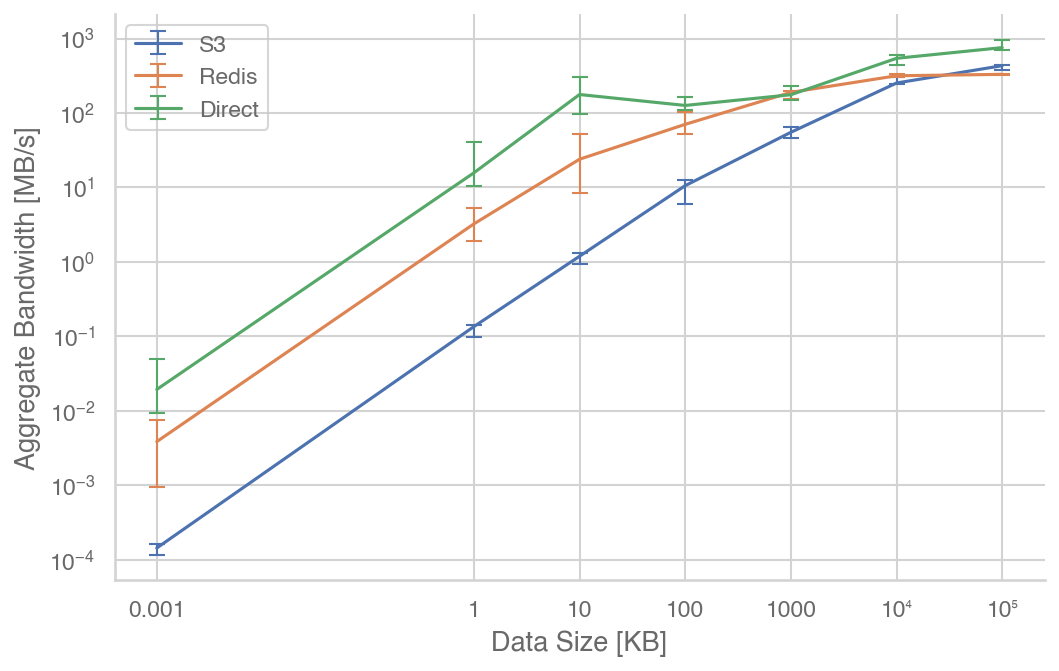

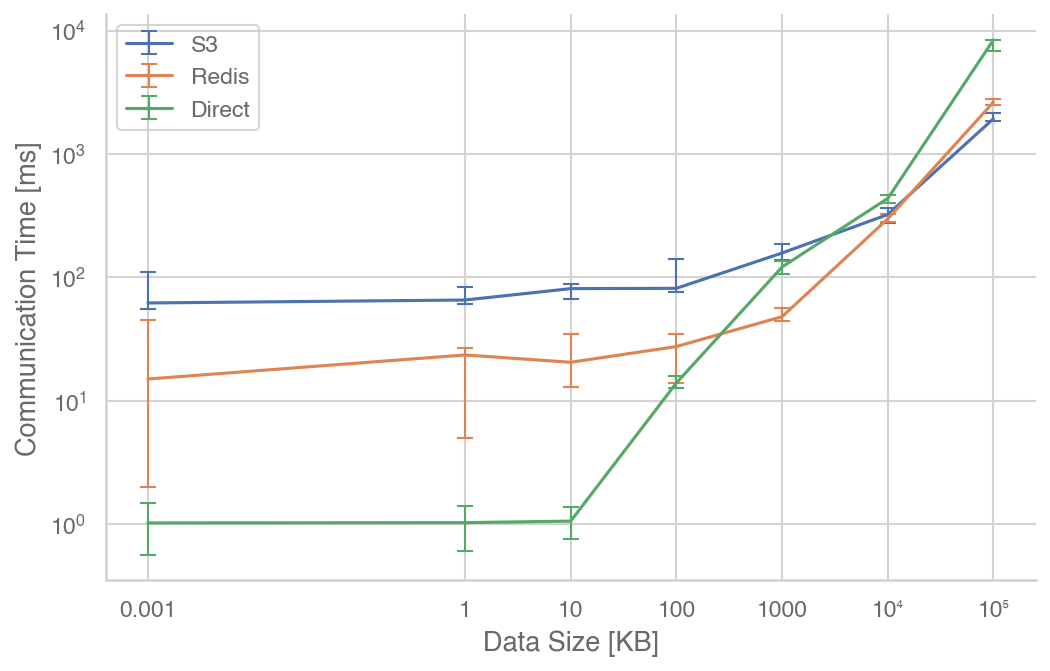

In [120]:
fig, fig2 = plt.figure(figsize=(8,5)), plt.figure(figsize=(8,5))
ax, ax2 = fig.add_subplot(), fig2.add_subplot()
one_to_many_performance_means = {}
one_to_many_performance_cis = {}
for experiment_name, exp_base_path in experiments.items():
    one_to_many_performance_means[experiment_name] = {}
    one_to_many_performance_cis[experiment_name] = {}
    var_base_path = os.path.join(exp_base_path, "one_to_many", "scaling_data", "out")
    res = parse_json(var_base_path)
    deltas = calc_deltas(res)
    plot_data = {}
    lower_error = []
    upper_error = []
    for file_size in sorted(deltas):
        if file_size == 500000000:
            continue
        values = list(deltas[file_size].values())
        agg_bandwidths = []
        for run_arr in values:
            agg_bandwidth = 0
            for latency in run_arr:
                if latency == 0:
                    latency = 1
                agg_bandwidth += (file_size / 1000000) / (latency / 1000)
            #agg_bandwidth /= len(run_arr)
            agg_bandwidths.append(agg_bandwidth)
        val = np.median(agg_bandwidths)
        plot_data[file_size / 1000] = val
        upper_ci = np.sort(agg_bandwidths)[-2] - val
        lower_ci = val - np.sort(agg_bandwidths)[1]
        lower_error.append(lower_ci)
        upper_error.append(upper_ci)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel("Data Size [KB]")
    ax.set_xticks(list(plot_data.keys()))
    ax.set_xticklabels(format_xticks(plot_data.keys()))
    ax.set_ylabel("Aggregate Bandwidth [MB/s]")
    ax.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], elinewidth=1, capsize=4, label=experiment_name)

    plot_data = {}
    lower_error = []
    upper_error = []
    for file_size in sorted(deltas):
        if file_size == 500000000:
            continue
        values = list(deltas[file_size].values())
        run_means = []
        run_latencies = []
        for run_arr in values:
            run_latencies.append(np.max(run_arr))
            run_means.append(np.mean(run_arr))
        val = np.median(run_latencies)
        one_to_many_performance_means[experiment_name][file_size / 1000] = np.mean(run_means)
        one_to_many_performance_cis[experiment_name][file_size / 1000] = scipy.stats.sem(run_means) * scipy.stats.t.ppf((1 + 0.95) / 2., len(run_means) - 1)
        plot_data[file_size / 1000] = val
        upper_ci = np.sort(run_latencies)[-2] - val
        lower_ci = val - np.sort(run_latencies)[1]
        lower_error.append(lower_ci)
        upper_error.append(upper_ci)
    print(plot_data)
    ax2.set_xscale('log')
    ax2.set_xlabel("Data Size [KB]")
    ax2.set_xticks(list(plot_data.keys()))
    ax2.set_xticklabels(format_xticks(plot_data.keys()))
    ax2.set_ylabel("Communication Time [ms]")
    ax2.set_yscale('log')
    ax2.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], elinewidth=1, capsize=4, label=experiment_name)

ax.legend()
ax2.legend()
fig.savefig(os.path.join(OUTPUT_PATH, "one-to-many_bandwidth.pdf"), bbox_inches='tight')
fig2.savefig(os.path.join(OUTPUT_PATH, "one-to-many_latency.pdf"), bbox_inches='tight')
plt.show()

### Scalability

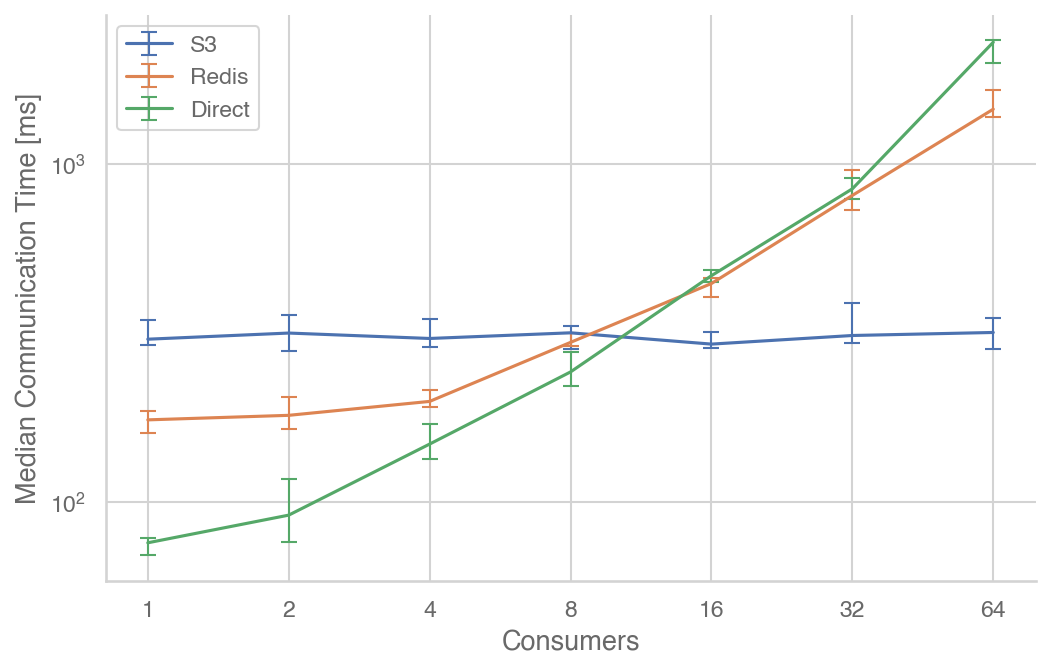

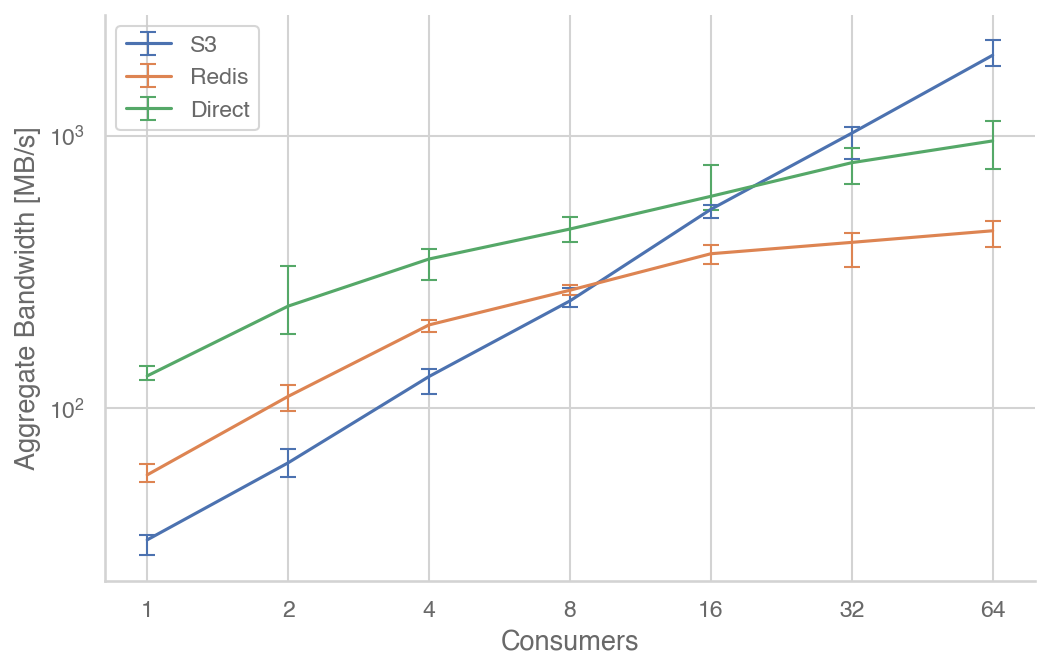

In [121]:
fig, fig2 = plt.figure(figsize=(8,5)), plt.figure(figsize=(8,5))
ax, ax2 = fig.add_subplot(), fig2.add_subplot()
one_to_many_scalability_means = {}
one_to_many_scalability_cis = {}
for experiment_name, exp_base_path in experiments.items():
    one_to_many_scalability_means[experiment_name] = {}
    one_to_many_scalability_cis[experiment_name] = {}
    experiment_base_folder = os.path.join(exp_base_path, "one_to_many", "scaling_lambdas", "out")
    plot_data = {}
    plot_data_bw = {}
    lower_error = []
    upper_error = []
    lower_error_bw = []
    upper_error_bw = []
    num_lambdas = []
    for subf in os.scandir(experiment_base_folder):
        if subf.name != "256" and subf.name != "128":
            num_lambdas.append(int(subf.name))
    for num_lambda in sorted(num_lambdas):    
        var_base_path = os.path.join(exp_base_path, "one_to_many", "scaling_lambdas", "out", str(num_lambda))
        res = parse_json(var_base_path)
        deltas = calc_deltas(res)
        run_medians = [np.median(run_data) for run_data in deltas[10000000].values()]
        plot_data[num_lambda] = np.median(run_medians)
        lower_error.append(np.median(run_medians) - np.sort(run_medians)[1])
        upper_error.append(np.sort(run_medians)[-2] - np.median(run_medians))

        values = list(deltas[10000000].values())
        means = [np.mean(run) for run in values]
        one_to_many_scalability_means[experiment_name][num_lambda] = np.mean(means)
        one_to_many_scalability_cis[experiment_name][num_lambda] = scipy.stats.sem(means) * scipy.stats.t.ppf((1 + 0.95) / 2., len(means) - 1)
        agg_bandwidths = []
        for run_arr in values:
            agg_bandwidth = 0
            for latency in run_arr:
                if latency == 0:
                    latency = 1
                agg_bandwidth += 10 / (latency / 1000)
            #agg_bandwidth /= len(run_arr)
            agg_bandwidths.append(agg_bandwidth)
        val = np.median(agg_bandwidths)
        plot_data_bw[num_lambda] = val
        upper_ci = np.sort(agg_bandwidths)[-2] - val
        lower_ci = val - np.sort(agg_bandwidths)[1]
        lower_error_bw.append(lower_ci)
        upper_error_bw.append(upper_ci)

    ax.set_xscale('log')
    ax.set_xlabel("Consumers")
    ax.set_xticks(list(plot_data.keys()))
    ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_ylabel("Median Communication Time [ms]")
    ax.set_yscale("log")
    ax.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], elinewidth=1, capsize=4, label=experiment_name)

    ax2.set_xscale('log')
    ax2.set_xlabel("Consumers")
    ax2.set_xticks(list(plot_data.keys()))
    ax2.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax2.set_ylabel("Aggregate Bandwidth [MB/s]")
    ax2.set_yscale('log')
    ax2.errorbar(plot_data_bw.keys(), plot_data_bw.values(), [lower_error_bw, upper_error_bw], elinewidth=1, capsize=4, label=experiment_name)

ax.legend()
ax2.legend()
fig.savefig(os.path.join(OUTPUT_PATH, "one-to-many_scalability_latency.pdf"), bbox_inches='tight')
fig2.savefig(os.path.join(OUTPUT_PATH, "one-to-many_scalability_bw.pdf"), bbox_inches='tight')
plt.show()

# Cost

In [3]:
# AWS eu-central-1 values
cost_model_params = {
    "p_faas": 0.0000166667,
    "p_vm": 0.0134,
    "p_kv": 0.038,
    "p_d": 0.00043 / 1000,
    "p_u": 0.0054 / 1000
}

In [4]:
def calc_faas_cost(P, C, t, R, M):
    return (P + C) * t * R * cost_model_params["p_faas"] * M

def calc_object_cost(P, C, R, g):
    c_up = P * R * cost_model_params["p_u"]
    c_down = C * P * R * g * cost_model_params["p_d"]
    return c_up + c_down

def calc_kv_cost(R, r):
    return R / r * cost_model_params["p_kv"]

def calc_direct_cost(R, r):
    return R / r * cost_model_params["p_vm"]

## P2P

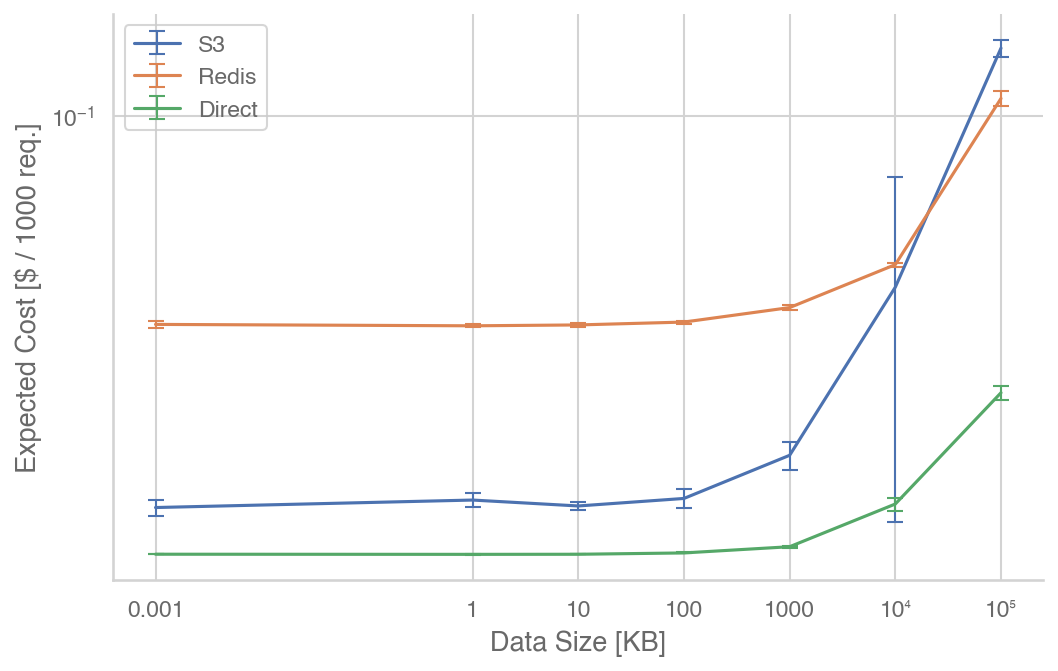

In [32]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Data Size [KB]")
ax.set_ylabel("Expected Cost [$ / 1000 req.]")
ax.set_xticks(list(p2p_experiment_means["S3"].keys()))
ax.set_xticklabels(format_xticks(p2p_experiment_means["S3"].keys()))
for experiment_name, means in p2p_experiment_means.items():
    if experiment_name == "Direct (UDT)":
        continue
    R = 1000
    r = 1000
    g = 20
    plot_data = {}
    lower_error, upper_error = [], []
    for file_size, mean in means.items():
        if file_size == 500000000:
            continue
        mean_lb = mean - p2p_experiment_cis[experiment_name][file_size]
        mean_ub = mean + p2p_experiment_cis[experiment_name][file_size]
        c_faas = calc_faas_cost(1, 1, mean / 1000, R, 2)
        c_faas_lb = calc_faas_cost(1, 1, mean_lb / 1000, R, 2)
        c_faas_ub = calc_faas_cost(1, 1, mean_ub / 1000, R, 2)
        if experiment_name == "S3":
            c_channel = calc_object_cost(1, 1, R, g)
        elif experiment_name == "Redis":
            c_channel = calc_kv_cost(R, r)
        elif experiment_name == "Direct":
            c_channel = calc_direct_cost(R, r)
        plot_data[file_size] = c_faas + c_channel
        upper_error.append(c_faas_ub - c_faas)
        lower_error.append(c_faas - c_faas_lb)
    ax.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], elinewidth=1, capsize=4, label=experiment_name)
    
ax.legend()
fig.savefig(os.path.join(OUTPUT_PATH, "p2p_costs.pdf"))
plt.show()

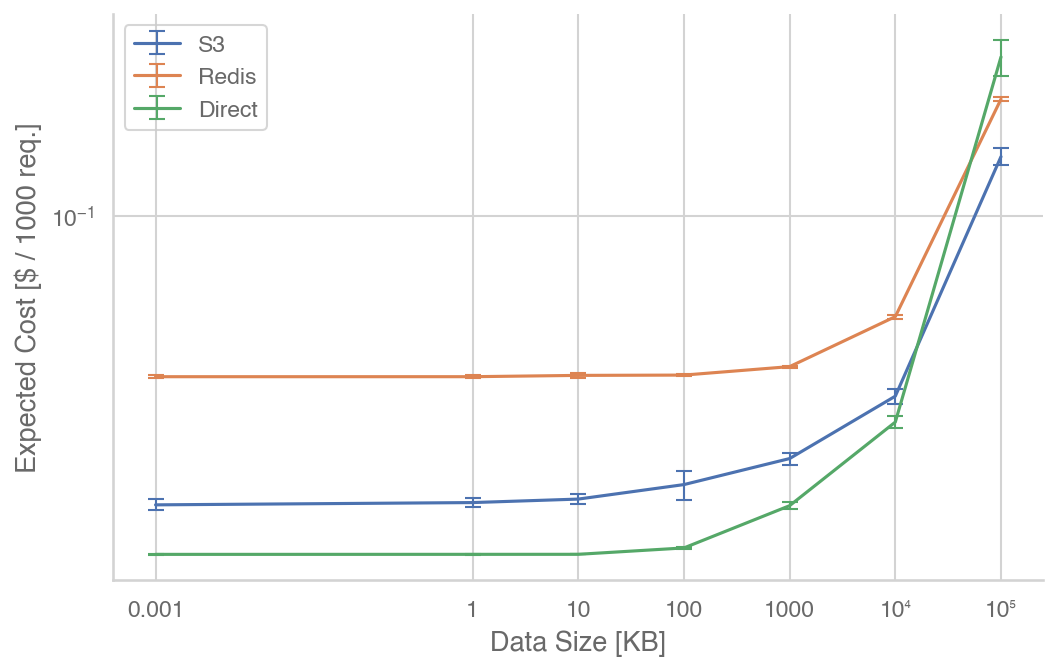

In [33]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Data Size [KB]")
ax.set_ylabel("Expected Cost [$ / 1000 req.]")
ax.set_xticks(list(one_to_many_performance_means["S3"].keys()))
ax.set_xticklabels(format_xticks(one_to_many_performance_means["S3"].keys()))
for experiment_name, means in one_to_many_performance_means.items():
    R = 1000
    r = 1000
    g = 20
    plot_data = {}
    lower_error, upper_error = [], []
    for file_size, mean in means.items():
        if file_size == 500000000:
            continue
        mean_lb = mean - one_to_many_performance_cis[experiment_name][file_size]
        mean_ub = mean + one_to_many_performance_cis[experiment_name][file_size]
        c_faas = calc_faas_cost(1, 1, mean / 1000, R, 2)
        c_faas_lb = calc_faas_cost(1, 1, mean_lb / 1000, R, 2)
        c_faas_ub = calc_faas_cost(1, 1, mean_ub / 1000, R, 2)
        if experiment_name == "S3":
            c_channel = calc_object_cost(1, 1, R, g)
        elif experiment_name == "Redis":
            c_channel = calc_kv_cost(R, r)
        elif experiment_name == "Direct":
            c_channel = calc_direct_cost(R, r)
        plot_data[file_size] = c_faas + c_channel
        upper_error.append(c_faas_ub - c_faas)
        lower_error.append(c_faas - c_faas_lb)
    ax.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], elinewidth=1, capsize=4, label=experiment_name)
    
ax.legend()
fig.savefig(os.path.join(OUTPUT_PATH, "one-to-many_performance_costs.pdf"))
plt.show()

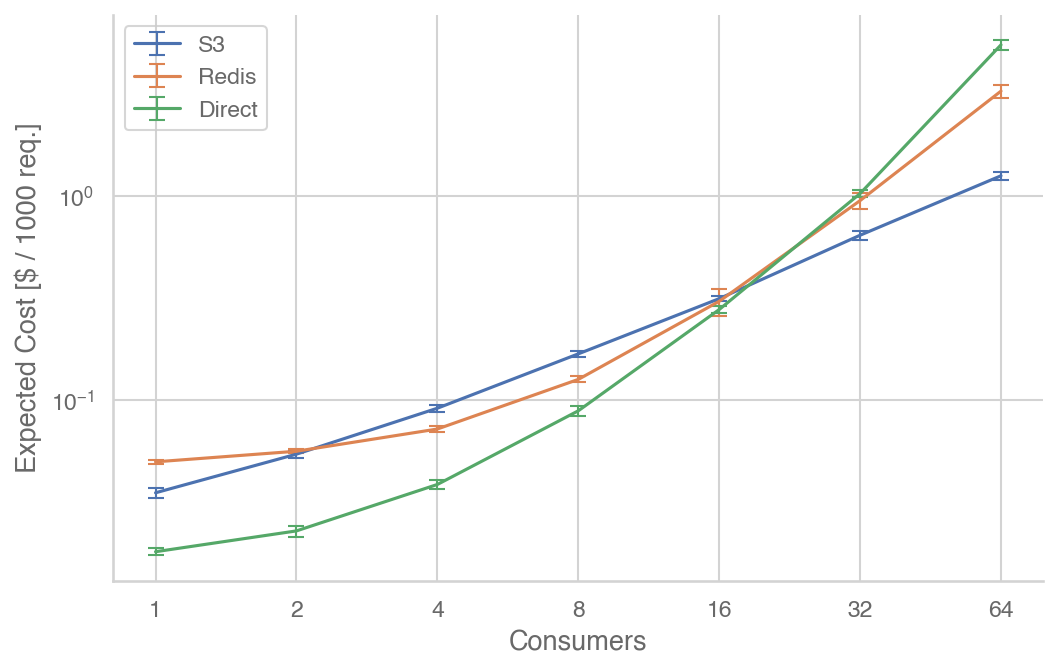

In [34]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Consumers")
ax.set_ylabel("Expected Cost [$ / 1000 req.]")
ax.set_xticks(list(one_to_many_scalability_means["S3"].keys()))
ax.set_xticklabels(format_xticks(one_to_many_scalability_means["S3"].keys()))
for experiment_name, means in one_to_many_scalability_means.items():
    R = 1000
    r = 1000
    g = 20
    plot_data = {}
    lower_error, upper_error = [], []
    for C, mean in means.items():
        mean_lb = mean - one_to_many_scalability_cis[experiment_name][C]
        mean_ub = mean + one_to_many_scalability_cis[experiment_name][C]
        c_faas = calc_faas_cost(1, C, mean / 1000, R, 2)
        c_faas_lb = calc_faas_cost(1, C, mean_lb / 1000, R, 2)
        c_faas_ub = calc_faas_cost(1, C, mean_ub / 1000, R, 2)
        if experiment_name == "S3":
            c_channel = calc_object_cost(1, C, R, g)
        elif experiment_name == "Redis":
            c_channel = calc_kv_cost(R, r)
        elif experiment_name == "Direct":
            c_channel = calc_direct_cost(R, r)
        plot_data[C] = c_faas + c_channel
        upper_error.append(c_faas_ub - c_faas)
        lower_error.append(c_faas - c_faas_lb)
    ax.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], elinewidth=1, capsize=4, label=experiment_name)
    
ax.legend()
fig.savefig(os.path.join(OUTPUT_PATH, "one-to-many_scalability_costs.pdf"))
plt.show()

# Performance Model

## Bandwidth Scaling, Single Consumer

No handles with labels found to put in legend.


S3
Intercept: 42.9
0.968
0.983
0.029
Redis
Intercept: 5.2
0.986
0.947
0.974
Direct
Intercept: 0.34
0.969
0.988
0.957


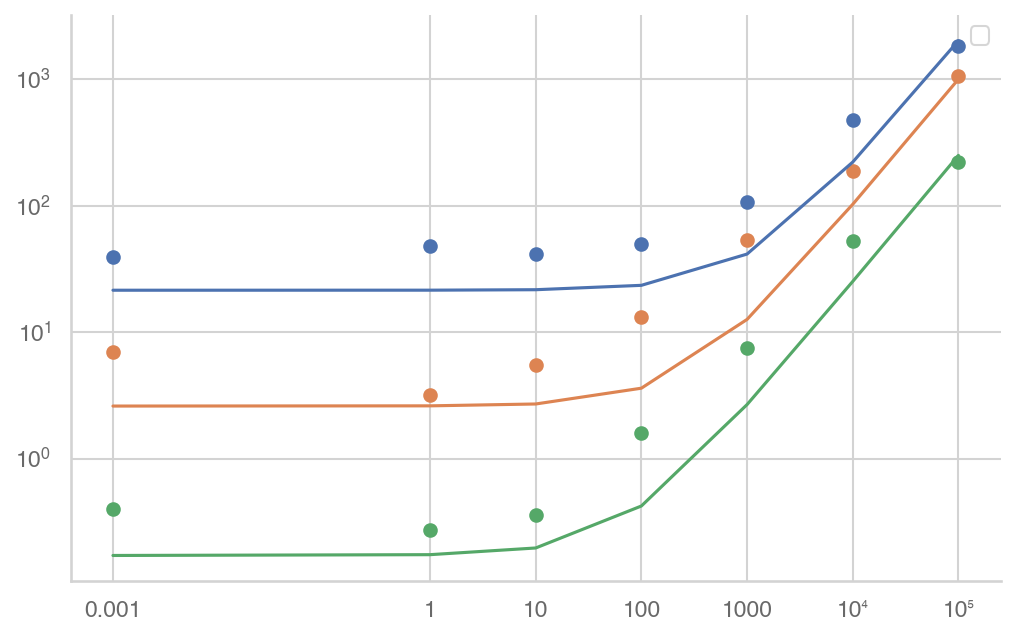

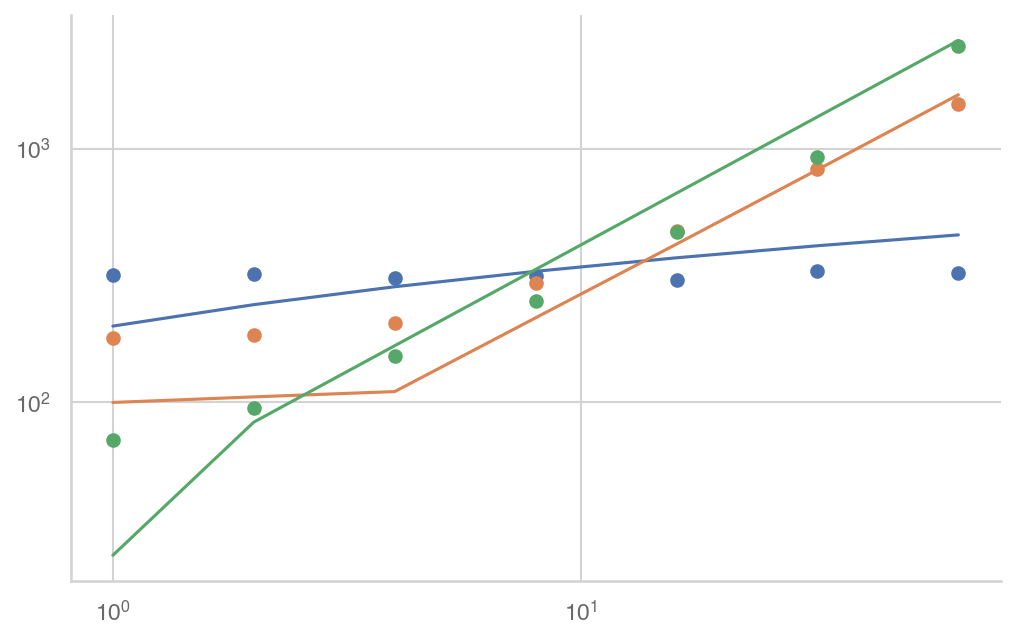

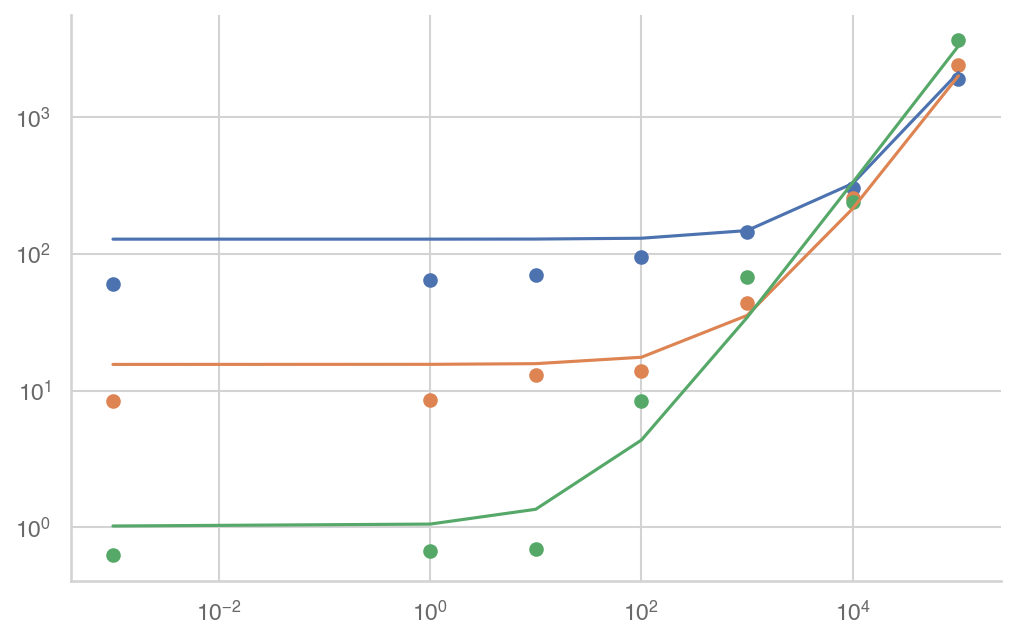

In [127]:
fig, fig2, fig3 = plt.figure(figsize=(8,5)), plt.figure(figsize=(8,5)), plt.figure(figsize=(8,5))
ax, ax2, ax3 = fig.add_subplot(), fig2.add_subplot(), fig3.add_subplot()
ax.set_xscale('log')
ax.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax.set_xticks(list(p2p_experiment_means["S3"].keys()))
ax.set_xticklabels(format_xticks(p2p_experiment_means["S3"].keys()))
regs = {}
intercepts = {}
for experiment_name, means in p2p_experiment_means.items():
    if experiment_name == "Direct (UDT)":
        continue
    print(experiment_name)
    plot_data = {}
    plot_data_size_consumers = {}
    lower_error, upper_error = [], []
    for file_size, mean in means.items():
        if file_size == 500000:
            continue
        mean_lb = mean - p2p_experiment_cis[experiment_name][file_size]
        mean_ub = mean + p2p_experiment_cis[experiment_name][file_size]
        plot_data[file_size] = mean
        plot_data_size_consumers[file_size] = mean
        upper_error.append(mean_ub - mean)
        lower_error.append(mean - mean_lb)
    multiple_data = {}
    for num_lambda, mean in one_to_many_scalability_means[experiment_name].items():
        multiple_data[num_lambda] = mean
        plot_data_size_consumers[10000 * num_lambda] = mean
    intercept = np.mean([plot_data[0.001], plot_data[1], plot_data[10]])
    print("Intercept: {}".format(round(intercept, 2)))

    from sklearn.metrics import r2_score
    s3_bandwidth = 50
    direct_bandwidth = 400
    redis_bw_single = 100
    redis_bw_multiple = 400
    preds = []
    for x in plot_data.keys():
        agg_size = x * 1.
        if experiment_name == "Direct":
            transfer_in_s = (agg_size / 1000) / direct_bandwidth
        elif experiment_name == "Redis":
            transfer_in_s = (agg_size / 1000) / redis_bw_single
        elif experiment_name == "S3":
            transfer_in_s = (agg_size / 1000) / s3_bandwidth
        #pred = intercept + transfer_in_s * 1000
        pred = 0.5 * intercept + transfer_in_s * 1000
        preds.append(pred)
    #print(np.array(preds).reshape(-1,1))
    #print(np.array(list(plot_data.values())).reshape(-1,1))
    ax.scatter(list(plot_data.keys()), list(plot_data.values()))
    ax.plot(list(plot_data.keys()), preds)
    print(round(r2_score(np.array(preds).reshape(-1,1), np.array(list(plot_data.values())).reshape(-1,1)), 3))
    
    preds = []
    for file_size, mean in one_to_many_performance_means[experiment_name].items():
        if file_size == 500000:
            continue
        agg_size = file_size * 8
        if experiment_name == "Direct":
            transfer_in_s = (agg_size / 1000) / (0.6 * direct_bandwidth)
        elif experiment_name == "Redis":
            transfer_in_s = (agg_size / 1000) / redis_bw_multiple
        elif experiment_name == "S3":
            transfer_in_s = (agg_size / 1000) / (8 * s3_bandwidth)
        pred = np.log2(8) * intercept + transfer_in_s * 1000
        preds.append(pred)
    #print(np.array(preds).reshape(-1,1))
    #print(np.array(list(one_to_many_performance_means[experiment_name].values())).reshape(-1,1))
    ax3.scatter(list(one_to_many_performance_means[experiment_name].keys()), list(one_to_many_performance_means[experiment_name].values()))
    ax3.plot(list(one_to_many_performance_means[experiment_name].keys()), preds)
    print(round(r2_score(np.array(preds).reshape(-1,1), np.array(list(one_to_many_performance_means[experiment_name].values())).reshape(-1,1)), 3))

    preds = []
    for num_lambda in multiple_data.keys():
        agg_size = 10000 * num_lambda
        if experiment_name == "Direct":
            if num_lambda == 1:
                factor = 1.0
            else:
                factor = 0.6
            transfer_in_s = (agg_size / 1000) / (factor * direct_bandwidth)
        elif experiment_name == "Redis":
            transfer_in_s = (agg_size / 1000) / np.min([num_lambda * redis_bw_single, redis_bw_multiple])
        elif experiment_name == "S3":
            transfer_in_s = (agg_size / 1000) / (num_lambda * s3_bandwidth)
        pred = np.log2(num_lambda) * intercept + transfer_in_s * 1000
        preds.append(pred)
    #print(np.array(preds).reshape(-1,1))
    #print(np.array(list(multiple_data.values())).reshape(-1,1))
    print(round(r2_score(np.array(preds).reshape(-1,1), np.array(list(multiple_data.values())).reshape(-1,1)), 3))
    ax2.scatter(list(multiple_data.keys()), list(multiple_data.values()))
    ax2.plot(list(multiple_data.keys()), preds)
    
ax.legend()
#fig.savefig(os.path.join(OUTPUT_PATH, "p2p_costs.pdf"))
plt.show()

# Cost Model Evaluation

## Model Parameters

In [5]:
perf_model_params = {
    "bw_obj": 50,
    "bw_kv_single": 100,
    "bw_kv_multiple": 400,
    "bw_direct": 400,
    "l_comm_obj_conn": 42.9 - 5. / 2,
    "l_comm_kv": 5.2,
    "l_comm_direct": 0.34
}

In [6]:
def get_obj_storage_latency(l_poll_obj, P, C, B):
    l_comm = perf_model_params["l_comm_obj_conn"] + l_poll_obj / 2
    agg_size = (P * C * B / 10. ** 6)
    b_channel = P * C * perf_model_params["bw_obj"]
    l_trans = agg_size / b_channel
    return np.log2(P + C) * l_comm + l_trans

def get_kv_store_latency(P, C, B):
    l_comm = perf_model_params["l_comm_kv"]
    agg_size = (P * C * B / 10. ** 6)
    b_channel = np.min([P * C * perf_model_params["bw_kv_single"], perf_model_params["bw_kv_multiple"]])
    l_trans = agg_size / b_channel
    return np.log2(P + C) * l_comm + l_trans

def get_direct_latency(P, C, B):
    l_comm = perf_model_params["l_comm_direct"]
    agg_size = (P * C * B / 10. ** 6)
    if C == 1:
        b_channel = perf_model_params["bw_direct"]
    else:
        b_channel = 0.6 * perf_model_params["bw_direct"]
    l_trans = agg_size / b_channel
    return np.log2(P + C) * l_comm + l_trans

## Query Parameters

In [5]:
l_poll_obj = 5 # [ms]
P = 1
B = 10. * 10. ** 6
G = 1000 # [ms]
R = 1000
M = 2 # [GiB]

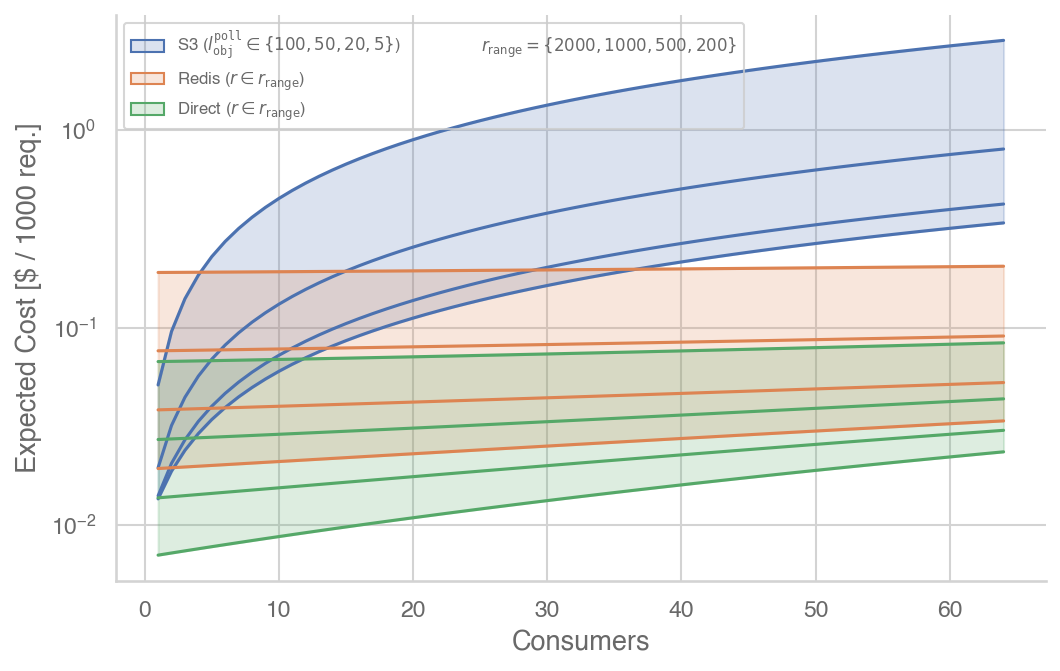

In [53]:
from matplotlib.patches import Patch
from matplotlib.colors import to_rgba
r_vals = [2000, 1000, 500, 200]
l_poll_vals = [100, 50, 20, 5]
legend_elements = [Patch(facecolor=to_rgba('C0', .2), edgecolor='C0', label=r'S3 ($l_\mathtt{obj}^\mathtt{poll} \in \{' + ",".join(str(s) for s in l_poll_vals) + r'\}$)'),
                   Patch(facecolor=to_rgba('C1', .2), edgecolor='C1', label=r'Redis ($r \in r_\mathrm{range}$)'),
                   Patch(facecolor=to_rgba('C2', .2), edgecolor='C2', label=r'Direct ($r \in r_\mathrm{range}$)'),
                   Patch(color="none", label=r'$r_\mathrm{range} = \{' + ",".join(str(s) for s in r_vals) + r'\}$'),
                   Patch(color="none")]
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()
ax.set_yscale('log')
ax.set_xlabel("Consumers")
ax.set_ylabel("Expected Cost [$ / 1000 req.]")
num_consumers = range(1, 65)
for l_poll_obj in l_poll_vals:
    plot_data = {}
    for C in num_consumers:
        l_comm = get_obj_storage_latency(l_poll_obj, P, C, B)
        g = (G / l_poll_obj) / 2
        total_cost = calc_faas_cost(P, C, l_comm / 1000, R, M) + calc_object_cost(P, C, R, g)
        plot_data[C] = total_cost
    linestyle = "solid"
    if l_poll_obj == np.min(l_poll_vals):
        max_line = plot_data
    elif l_poll_obj == np.max(l_poll_vals):
        min_line = plot_data
    else:
        linestyle = "solid"
    ax.plot(plot_data.keys(), plot_data.values(), color="C0", linestyle=linestyle)
ax.fill_between(min_line.keys(), min_line.values(), max_line.values(), alpha=.2, color="C0")

for r in r_vals:
    plot_data_kv = {}
    plot_data_direct = {}
    for C in num_consumers:
        l_kv = get_kv_store_latency(P, C, B)
        l_direct = get_direct_latency(P, C, B)
        total_cost_kv = calc_faas_cost(P, C, l_kv / 1000, R, M) + calc_kv_cost(R, r)
        total_cost_direct = calc_faas_cost(P, C, l_direct / 1000, R, M) + calc_direct_cost(R, r)
        plot_data_kv[C] = total_cost_kv
        plot_data_direct[C] = total_cost_direct
    linestyle = "solid"
    if r == np.min(r_vals):
        max_line_kv = plot_data_kv
        max_line_direct = plot_data_direct
    elif r == np.max(r_vals):
        min_line_kv = plot_data_kv
        min_line_direct = plot_data_direct
    else:
        linestyle = "solid"
    ax.plot(plot_data_kv.keys(), plot_data_kv.values(), color="C1", linestyle=linestyle)
    ax.plot(plot_data_direct.keys(), plot_data_direct.values(), color="C2", linestyle=linestyle)
ax.fill_between(min_line_kv.keys(), min_line_kv.values(), max_line_kv.values(), alpha=.2, color="C1")
ax.fill_between(min_line_direct.keys(), min_line_direct.values(), max_line_direct.values(), alpha=.2, color="C2")
ax.legend(handles=legend_elements, prop={"size": 8}, ncol=2, loc="upper left")
fig.savefig(os.path.join(OUTPUT_PATH, "evaluation_costmodel_ranges.pdf"))

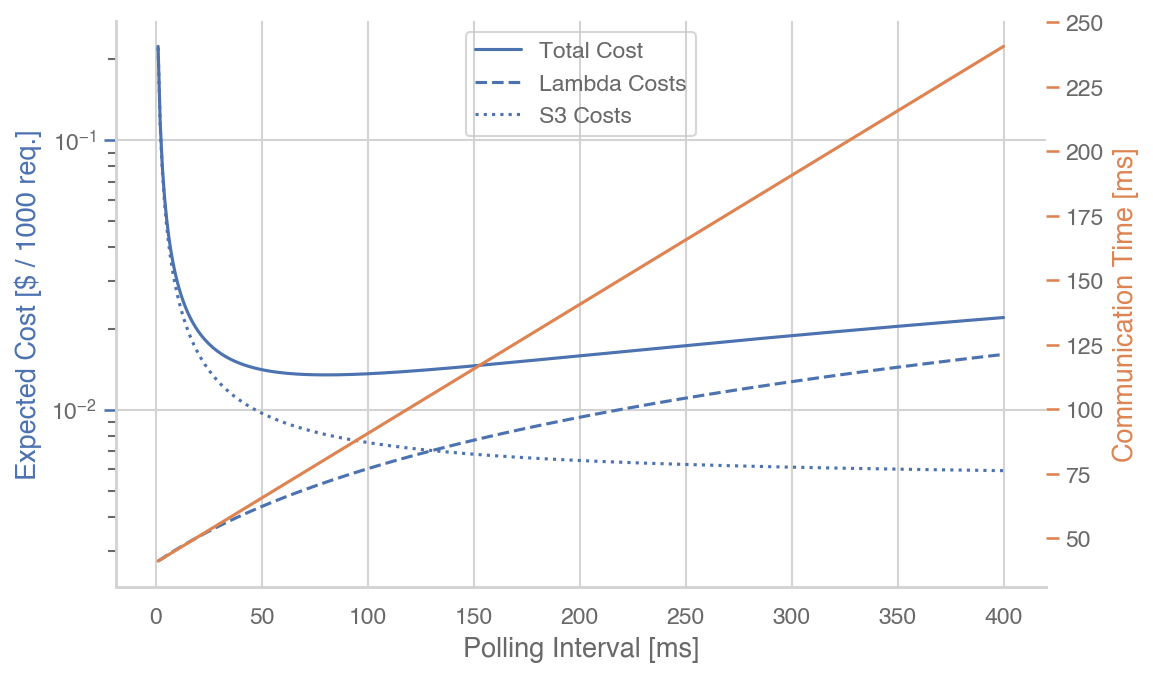

In [54]:
fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot()
ax1.set_xlabel("Polling Interval [ms]")
ax1.set_ylabel("Expected Cost [$ / 1000 req.]", color="C0")
ax1.set_yscale('log')
C = 1
for experiment_name in ["S3"]:
    plot_data_lat = {}
    plot_data_costs = {}
    plot_data_faas_costs = {}
    plot_data_object_costs = {}
    for l_poll_obj in range(1, 401):
        l_comm = get_obj_storage_latency(l_poll_obj, P, C, B)
        plot_data_lat[l_poll_obj] = l_comm
        g = (G / l_poll_obj) / 2
        faas_cost = calc_faas_cost(P, C, l_comm / 1000, R, M)
        object_cost = calc_object_cost(P, C, R, g)
        total_cost = faas_cost + object_cost
        plot_data_costs[l_poll_obj] = total_cost
        plot_data_faas_costs[l_poll_obj] = faas_cost
        plot_data_object_costs[l_poll_obj] = object_cost
    ax1.plot(plot_data_costs.keys(), plot_data_costs.values(), color="C0", label="Total Cost")
    ax1.plot(plot_data_faas_costs.keys(), plot_data_faas_costs.values(), color="C0", linestyle='dashed', label="Lambda Costs")
    ax1.plot(plot_data_object_costs.keys(), plot_data_object_costs.values(), color="C0", linestyle='dotted', label="S3 Costs")
    ax1.tick_params(axis='y', color="C0")
    ax2 = ax1.twinx()
    ax2.grid(None)
    ax2.set_ylabel("Communication Time [ms]", color="C1")
    ax2.tick_params(axis='y', color="C1")
    ax2.plot(plot_data_lat.keys(), plot_data_lat.values(), color="C1")
    
ax1.legend(loc="upper center")
fig.savefig(os.path.join(OUTPUT_PATH, "evaluation_costmodel_s3costperf.pdf"))

# SMI

## Comparison with MPI

In [17]:
MPI_BASE_BATH = os.path.join(BASE_PATH, 'mpi', 'res')
SMI_BASE_BATH = os.path.join(BASE_PATH, 'smi', 'res')
NUM_NODES = [2, 4, 8, 16, 32]
experiments = ['allreduce', 'bcast', 'gather', 'reduce', 'scan', 'scatter']

In [18]:
vals = {}
for experiment in experiments:
    print(experiment)
    data = {"n": [], "latency": [], "method": []}
    for num_node in NUM_NODES:
        mpi_path = os.path.join(MPI_BASE_BATH, "{}_{}.txt".format(experiment, num_node))
        smi_path = os.path.join(SMI_BASE_BATH, "{}_{}.txt".format(experiment, num_node))
        res_rounds = {}
        start_times = {}
        with open(mpi_path) as mpi_file:
            lines = mpi_file.readlines()
            for line in lines:
                parts = line.rstrip().split(",")
                peer_id = int(parts[0])
                exchange_num = int(parts[1])
                val = int(parts[2])
                if peer_id == 0:
                    start_times[exchange_num] = val
                else:
                    if exchange_num not in res_rounds:
                        res_rounds[exchange_num] = [val]
                    else:
                        res_rounds[exchange_num].append(val)
        for exchange_num, values in res_rounds.items():
            data["n"].append(num_node)
            if experiment == "gather":
                data["latency"].append(start_times[exchange_num] - min(values))
            else:
                data["latency"].append(max(values) - start_times[exchange_num])
            data["method"].append("Open MPI")
        res_rounds = {}
        start_times = {}
        with open(smi_path) as smi_file:
            lines = smi_file.readlines()
            for line in lines:
                parts = line.rstrip().split(",")
                peer_id = int(parts[0])
                exchange_num = int(parts[1])
                val = int(parts[2])
                if peer_id == 0:
                    start_times[exchange_num] = val
                else:
                    if exchange_num not in res_rounds:
                        res_rounds[exchange_num] = [val]
                    else:
                        res_rounds[exchange_num].append(val)
        for exchange_num, values in res_rounds.items():
            data["n"].append(num_node)
            if experiment == "gather":
                data["latency"].append(start_times[exchange_num] - min(values))
            else:
                data["latency"].append(max(values) - start_times[exchange_num])            
            data["method"].append("SMI")
    vals[experiment] = pd.DataFrame(data)

display(vals["allreduce"].groupby(['n', 'method']).max())
display(vals["bcast"].groupby(['n', 'method']).min())
display(vals["gather"].groupby(['n', 'method']).max())
display(vals["reduce"].groupby(['n', 'method']).max())
display(vals["scan"].groupby(['n', 'method']).max())
display(vals["scatter"].groupby(['n', 'method']).max())
mpi_bench = vals

allreduce
bcast
gather
reduce
scan
scatter


latency
n  method           
2  Open MPI      801
   SMI          2282
4  Open MPI      788
   SMI          2554
8  Open MPI     1586
   SMI          5443
16 Open MPI     2316
   SMI          6261
32 Open MPI     2387
   SMI          8683

latency
n  method           
2  Open MPI       96
   SMI            89
4  Open MPI      200
   SMI           195
8  Open MPI      280
   SMI           301
16 Open MPI      337
   SMI           355
32 Open MPI      505
   SMI           440

latency
n  method           
2  Open MPI      947
   SMI           646
4  Open MPI     1282
   SMI          2014
8  Open MPI     2525
   SMI          1702
16 Open MPI     3162
   SMI          4401
32 Open MPI     6370
   SMI          6261

latency
n  method           
2  Open MPI     2414
   SMI          1859
4  Open MPI      807
   SMI          1644
8  Open MPI      753
   SMI          2241
16 Open MPI     4026
   SMI          1753
32 Open MPI     3610
   SMI         10550

latency
n  method           
2  Open MPI      227
   SMI          1847
4  Open MPI      566
   SMI          1997
8  Open MPI     1702
   SMI          5909
16 Open MPI     6125
   SMI          3478
32 Open MPI    10546
   SMI          8773

latency
n  method           
2  Open MPI     1189
   SMI          1583
4  Open MPI      997
   SMI          1134
8  Open MPI     1441
   SMI          2144
16 Open MPI     2729
   SMI          5037
32 Open MPI     2909
   SMI          2521

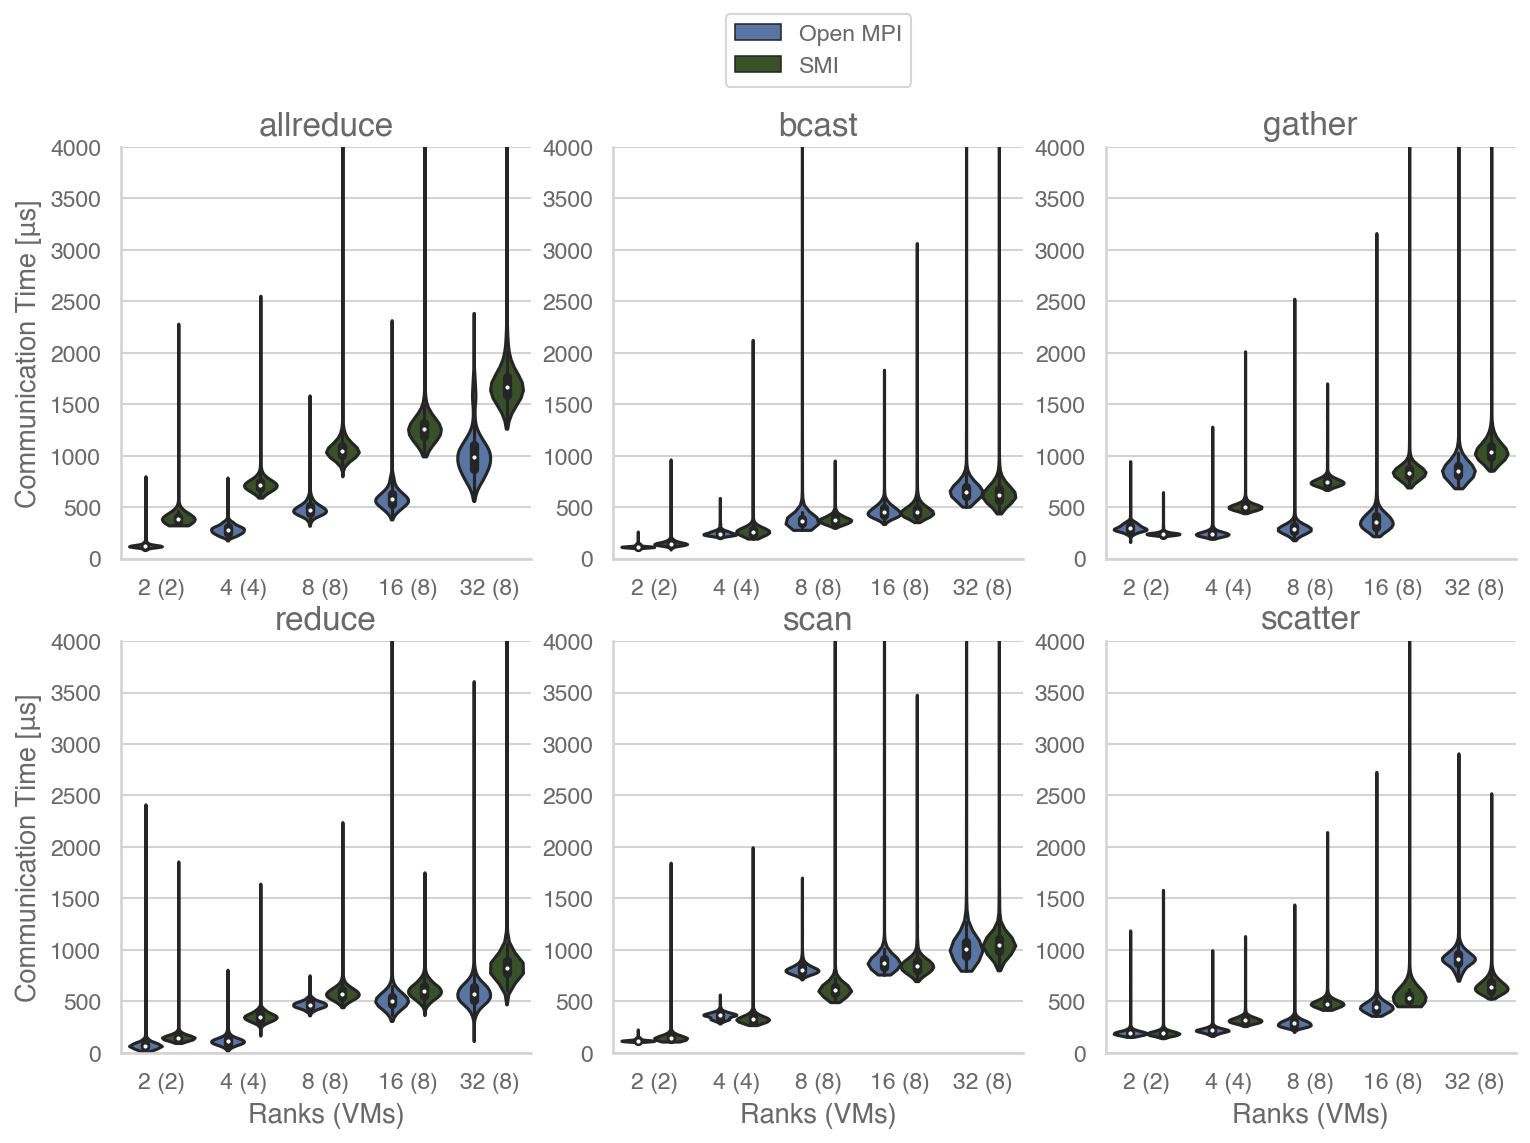

In [19]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
my_pal = {"Open MPI": "b", "SMI": "#385723"}
axs[0,0].set_ylim(0,4000)
axs[0,0].set_title("allreduce")
axs[0,1].set_ylim(0,4000)
axs[0,1].set_title("bcast")
axs[0,2].set_ylim(0,4000)
axs[0,2].set_title("gather")
axs[1,0].set_ylim(0,4000)
axs[1,0].set_title("reduce")
axs[1,1].set_ylim(0,4000)
axs[1,1].set_title("scan")
axs[1,2].set_ylim(0,4000)
axs[1,2].set_title("scatter")

sns.violinplot(x="n", y="latency", hue="method", data=vals["allreduce"], ax=axs[0, 0], cut=0, palette=my_pal, scale="count")
sns.violinplot(x="n", y="latency", hue="method", data=vals["bcast"], ax=axs[0, 1], cut=0, palette=my_pal, scale="count")
sns.violinplot(x="n", y="latency", hue="method", data=vals["gather"], ax=axs[0, 2], cut=0, palette=my_pal, scale="count")
sns.violinplot(x="n", y="latency", hue="method", data=vals["reduce"], ax=axs[1, 0], cut=0, palette=my_pal, scale="count")
sns.violinplot(x="n", y="latency", hue="method", data=vals["scan"], ax=axs[1, 1], cut=0, palette=my_pal, scale="count")
sns.violinplot(x="n", y="latency", hue="method", data=vals["scatter"], ax=axs[1, 2], cut=0, palette=my_pal, scale="count")

for ix,iy in np.ndindex(axs.shape):
    axs[ix,iy].set_xticklabels(["2 (2)", "4 (4)", "8 (8)", "16 (8)", "32 (8)"])
    if ix == 0 and iy == 1:
        axs[ix,iy].legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), fancybox=True)
    else:
        axs[ix,iy].legend([],[], frameon=False)
    if ix == 1:
        axs[ix,iy].set_xlabel("Ranks (VMs)")
    else:
        axs[ix,iy].set_xlabel(None)
    if iy == 0:
        axs[ix,iy].set_ylabel("Communication Time [μs]")
    else:
        axs[ix,iy].set_ylabel(None)
fig.savefig(os.path.join(OUTPUT_PATH, "smi_benchmark_mpi.pdf"))


## Serverless Collective Evaluation

In [8]:
DIRECT_BASE_PATH = os.path.join(BASE_PATH, 'smi', 'out_lambda_direct')
REDIS_BASE_BATH = os.path.join(BASE_PATH, 'smi', 'out_lambda_redis')
S3_BASE_BATH = os.path.join(BASE_PATH, 'smi', 'out_lambda_s3')

In [41]:
vals = {}
NUM_NODES = [2, 4, 8, 16, 32, 64, 128, 256]
for experiment in experiments:
    data = {"n": [], "latency": [], "method": []}
    for num_node in NUM_NODES:
        for base_path, channel in [(DIRECT_BASE_PATH, "Direct"), (REDIS_BASE_BATH, "Redis"), (S3_BASE_BATH, "S3")]:
            if num_node > 32 and channel == "S3":
                continue
            if num_node > 64 and channel == "Redis":
                continue
            res_rounds = {}
            start_times = {}
            for i in range(num_node):
                path = os.path.join(base_path, "{}_{}_{}.json".format(experiment, num_node, i))
                with open(path) as file:
                    lines = file.readlines()
                    for line in lines:
                        parts = line.rstrip().split(",")
                        peer_id = int(parts[0])
                        exchange_num = int(parts[1])
                        val = int(parts[2])
                        if peer_id == 0:
                            start_times[exchange_num] = val
                        else:
                            if exchange_num not in res_rounds:
                                res_rounds[exchange_num] = [val]
                            else:
                                res_rounds[exchange_num].append(val)
            for exchange_num, values in res_rounds.items():
                data["n"].append(num_node)
                if experiment == "gather":
                    data["latency"].append(start_times[exchange_num] - min(values))
                else:
                    data["latency"].append(max(values) - start_times[exchange_num])
                data["method"].append(channel)
        vals[experiment] = pd.DataFrame(data)

for experiment in experiments:
    print(experiment)
    display(vals[experiment].groupby(['n', 'method']).mean())
lambda_bench = vals

allreduce


latency
n   method               
2   Direct    1040.533333
    Redis     4645.100000
    S3      108971.800000
4   Direct    2323.066667
    Redis     8236.733333
    S3      156254.700000
8   Direct    3995.766667
    Redis    12021.733333
    S3      285996.700000
16  Direct    5022.800000
    Redis    27981.633333
    S3      369697.400000
32  Direct   10028.900000
    Redis    51662.566667
    S3      600348.600000
64  Direct   11236.866667
    Redis   230199.333333
128 Direct   22931.033333
256 Direct   53593.300000

bcast


latency
n   method              
2   Direct    998.200000
    Redis    1911.600000
    S3      42280.400000
4   Direct    778.466667
    Redis    2735.133333
    S3      49379.600000
8   Direct   1028.500000
    Redis    2823.900000
    S3      67196.900000
16  Direct   2632.400000
    Redis    4125.833333
    S3      59371.900000
32  Direct   3220.166667
    Redis   12316.466667
    S3      95567.000000
64  Direct   4896.966667
    Redis   40465.900000
128 Direct   8306.700000
256 Direct  26570.733333

gather


latency
n   method               
2   Direct     719.800000
    Redis     1987.433333
    S3       56301.000000
4   Direct    1185.033333
    Redis     4425.533333
    S3       99532.700000
8   Direct    2460.566667
    Redis    10478.233333
    S3      178098.100000
16  Direct    3151.433333
    Redis    17681.900000
    S3      380872.600000
32  Direct    4949.933333
    Redis    39745.400000
    S3      598314.500000
64  Direct   11728.600000
    Redis   147251.600000
128 Direct    9366.133333
256 Direct   20237.166667

reduce


latency
n   method               
2   Direct     495.500000
    Redis     1781.566667
    S3       36746.400000
4   Direct     979.100000
    Redis     1786.466667
    S3       32523.500000
8   Direct    2050.133333
    Redis     3217.400000
    S3       46436.500000
16  Direct    3461.433333
    Redis     6889.033333
    S3       60714.900000
32  Direct    6494.266667
    Redis    25463.566667
    S3      105501.400000
64  Direct    6451.100000
    Redis    40859.966667
128 Direct    9404.133333
256 Direct   16532.900000

scan


latency
n   method               
2   Direct     757.666667
    Redis     3168.333333
    S3       61062.100000
4   Direct    1062.466667
    Redis     5195.933333
    S3      112032.400000
8   Direct    1509.266667
    Redis     9788.366667
    S3      168780.800000
16  Direct    3595.466667
    Redis    16778.400000
    S3      265502.100000
32  Direct    5369.200000
    Redis    40565.166667
    S3      513525.100000
64  Direct    8179.600000
    Redis   184719.200000
128 Direct   12221.000000
256 Direct   28415.533333

scatter


latency
n   method               
2   Direct     127.400000
    Redis     2402.333333
    S3       58608.500000
4   Direct     939.800000
    Redis     4393.766667
    S3      114011.400000
8   Direct    2007.533333
    Redis     8188.666667
    S3      276568.800000
16  Direct    3777.266667
    Redis    14803.966667
    S3      484673.800000
32  Direct    3712.066667
    Redis    36371.566667
    S3      922380.300000
64  Direct    7779.700000
    Redis   123478.600000
128 Direct   15899.200000
256 Direct   19221.333333

In [42]:
def get_model_op_latency(n, method, experiment, size):
    if method == "Direct":
        if experiment == "allreduce":
            return 2 * np.log2(n) * get_direct_latency(1, 1, size)
        elif experiment == "bcast":
            return np.log2(n) * get_direct_latency(1, 1, size)
        elif experiment == "gather" or experiment == "scatter":
            latency = 0
            for i in range(1, int(np.log2(n)) + 1):
                latency += get_direct_latency(1, 1, i * size)
            return latency
        elif experiment == "reduce":
            return np.log2(n) * get_direct_latency(1, 1, size)
        elif experiment == "scan":
            return 2 * np.log2(n) * get_direct_latency(1, 1, size)
    elif method == "Redis":
        if experiment == "allreduce":
            red = get_kv_store_latency(n - 1, 1, size)
            bcast = get_kv_store_latency(1, n - 1, size)
            return red + bcast
        elif experiment == "bcast":
            return get_kv_store_latency(1, n - 1, size)
        elif experiment == "gather":
            return get_kv_store_latency(n - 1, 1, size)
        elif experiment == "reduce":
            return get_kv_store_latency(n - 1, 1, size)
        elif experiment == "scan":
            return get_kv_store_latency(n - 1, 1, size)
        elif experiment == "scatter":
            return get_kv_store_latency(1, n - 1, size)
    elif method == "S3":
        if experiment == "allreduce":
            red = get_obj_storage_latency(20, n - 1, 1, size)
            bcast = get_obj_storage_latency(20, 1, n - 1, size)
            return red + bcast
        elif experiment == "bcast":
            return get_obj_storage_latency(20, 1, n - 1, size)
        elif experiment == "gather":
            return get_obj_storage_latency(20, n - 1, 1, size)
        elif experiment == "reduce":
            return get_obj_storage_latency(20, n - 1, 1, size)
        elif experiment == "scan":
            return get_obj_storage_latency(20, n - 1, 1, size)
        elif experiment == "scatter":
            return get_obj_storage_latency(20, 1, n - 1, size)

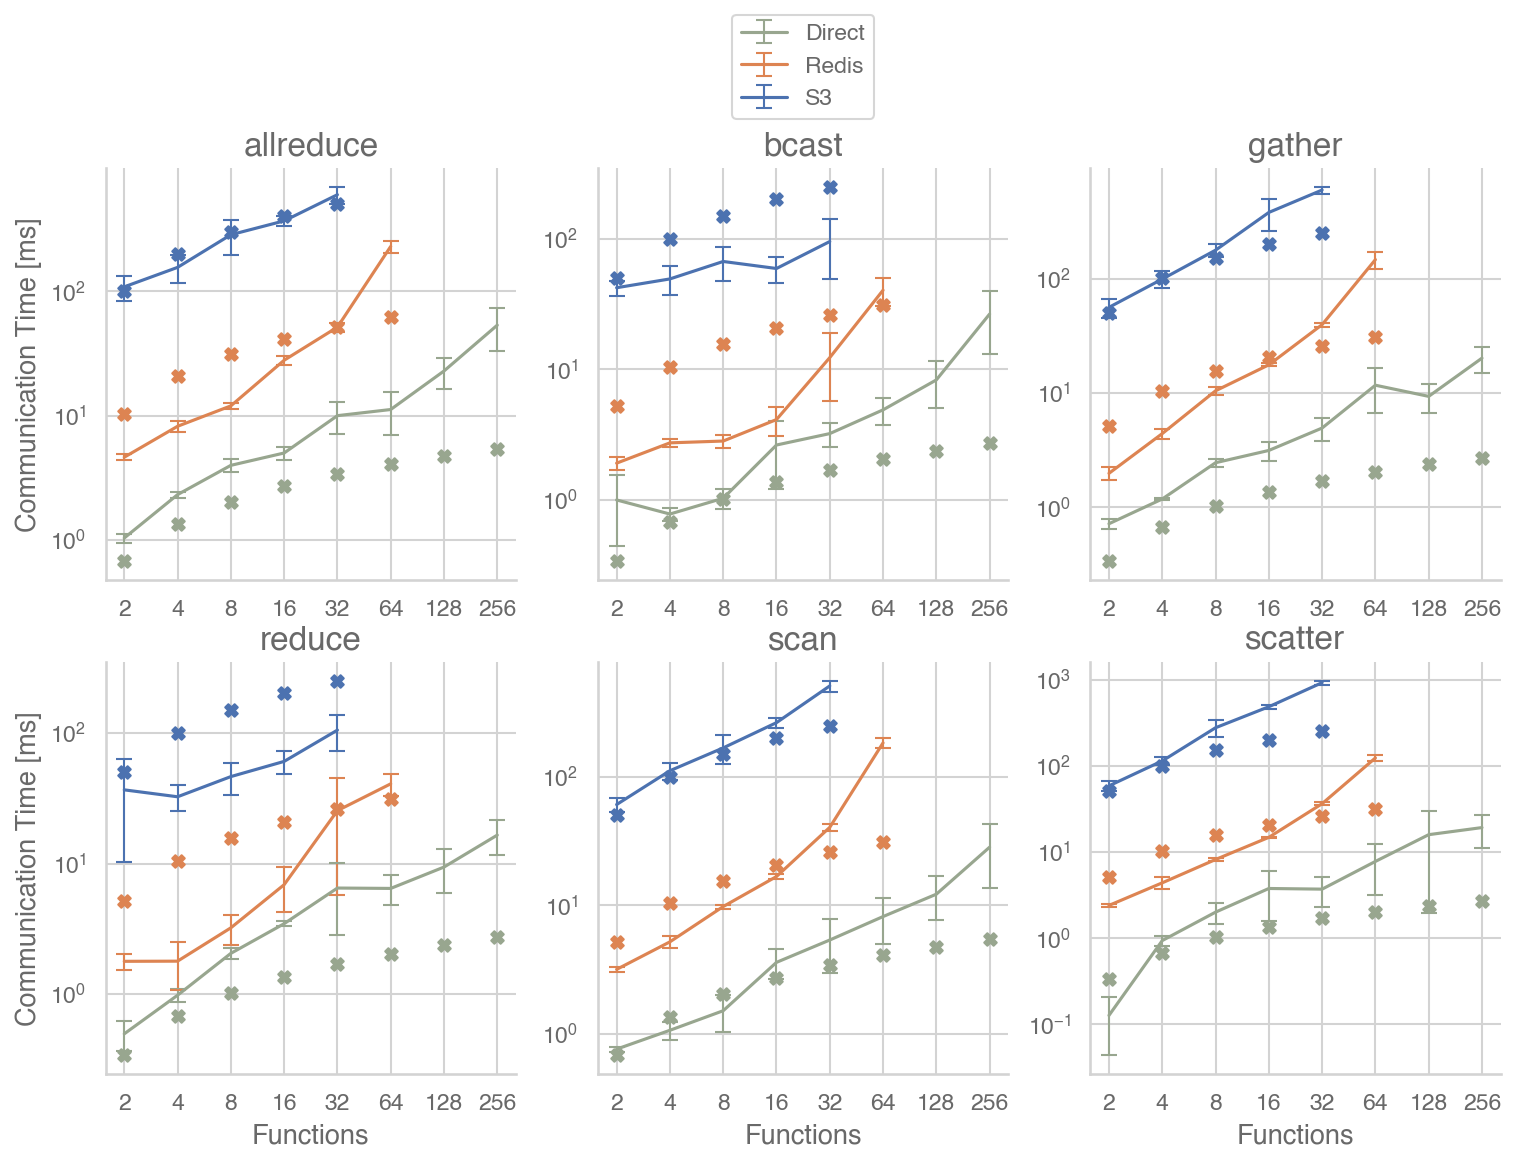

In [47]:

my_pal = {
    "Redis": "C1", 
    "Direct": "#98a68f", 
    "S3": "C0"
}
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
for method in ["Direct", "Redis", "S3"]:
    ix, iy = 0, 0
    for experiment in experiments:
        plot_data = {}
        error = []
        preds = {}
        for num_node in NUM_NODES:
            if num_node > 32 and method == "S3":
                continue
            if num_node > 64 and method == "Redis":
                continue
            experiment_sizes = {
                "allreduce": 4,
                "bcast": 4,
                "gather": 4992 / num_node,
                "reduce": 4,
                "scan": 4,
                "scatter": 4992 / num_node
            }
            model_pred = get_model_op_latency(num_node, method, experiment, experiment_sizes[experiment])
            preds[num_node] = model_pred
            values = vals[experiment].loc[(vals[experiment]['n'] == num_node) & (vals[experiment]['method'] == method)]['latency']
            mean = np.mean(values)
            ci = scipy.stats.sem(values) * scipy.stats.t.ppf((1 + 0.95) / 2., len(values) - 1)
            plot_data[num_node] = mean / 1000
            error.append(ci / 1000)
        axs[ix,iy].errorbar(plot_data.keys(), plot_data.values(), error, elinewidth=1, capsize=4, label=method, c=my_pal[method])
        axs[ix,iy].scatter(preds.keys(), preds.values(), marker="X", c=my_pal[method])
        axs[ix,iy].set_title(experiment)
        axs[ix,iy].set_yscale('log')
        axs[ix,iy].set_xscale('log')
        axs[ix,iy].set_xticks(NUM_NODES)
        axs[ix,iy].set_xticklabels(NUM_NODES)
        if ix == 0 and iy == 1:
            axs[ix,iy].legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), fancybox=True)
        else:
            axs[ix,iy].legend([],[], frameon=False)
        if ix == 1:
            axs[ix,iy].set_xlabel("Functions")
        else:
            axs[ix,iy].set_xlabel(None)
        if iy == 0:
            axs[ix,iy].set_ylabel("Communication Time [ms]")
        else:
            axs[ix,iy].set_ylabel(None)
        iy += 1
        if iy > 2:
            iy = 0
            ix = 1
fig.savefig(os.path.join(OUTPUT_PATH, "smi_benchmark_collectives.pdf"))

### Merged Figure (EC2 & Lambda)

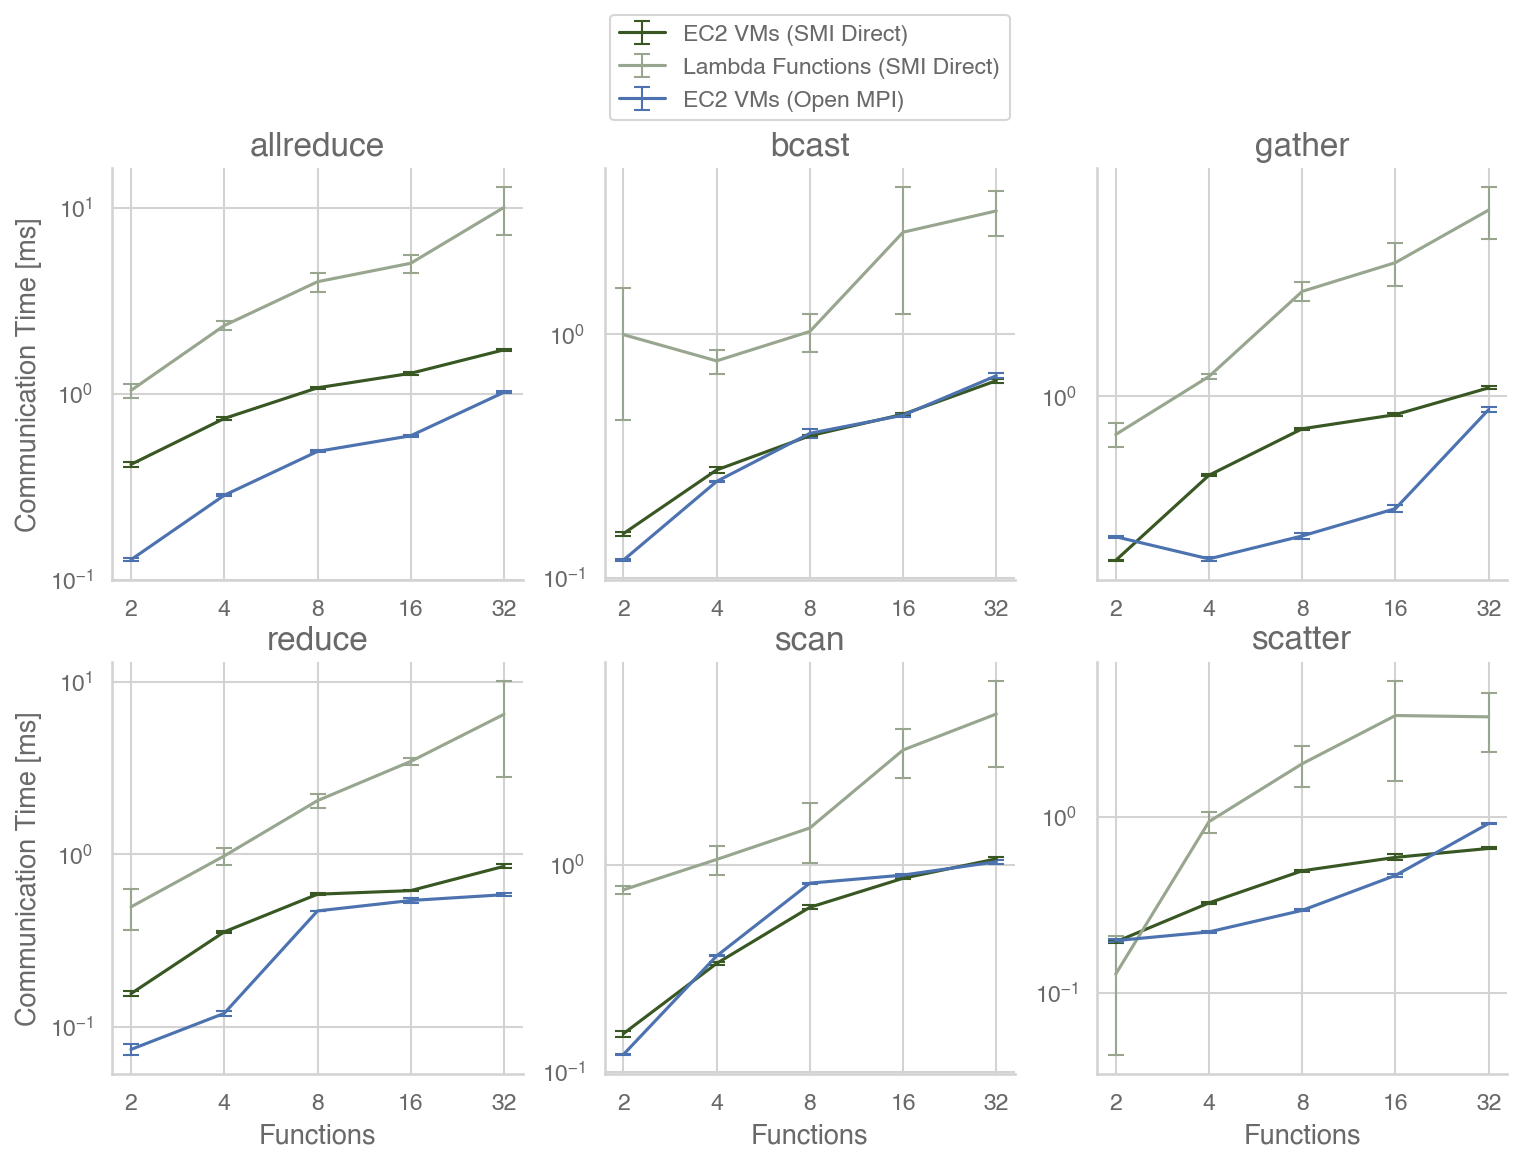

In [37]:
NUM_NODES = [2, 4, 8, 16, 32]
vals = {}
for experiment in experiments:
    vals[experiment] = pd.concat([mpi_bench[experiment][(mpi_bench[experiment]["method"] == "SMI") | (mpi_bench[experiment]["method"] == "Open MPI")], lambda_bench[experiment][lambda_bench[experiment]["method"] == "Direct"]])
    vals[experiment]["method"] = vals[experiment]["method"].replace({"SMI": "EC2 VMs (SMI Direct)", "Open MPI": "EC2 VMs (Open MPI)", "Direct": "Lambda Functions (SMI Direct)"})
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
my_pal = {
    "EC2 VMs (SMI Direct)": "#385723", 
    "Lambda Functions (SMI Direct)": "#98a68f", 
    "EC2 VMs (Open MPI)": "b"
}
for method in ["EC2 VMs (SMI Direct)", "Lambda Functions (SMI Direct)", "EC2 VMs (Open MPI)"]:
    ix, iy = 0, 0
    for experiment in experiments:
        plot_data = {}
        error = []
        preds = {}
        for num_node in NUM_NODES:
            experiment_sizes = {
                "allreduce": 4,
                "bcast": 4,
                "gather": 4992 / num_node,
                "reduce": 4,
                "scan": 4,
                "scatter": 4992 / num_node
            }
            values = vals[experiment].loc[(vals[experiment]['n'] == num_node) & (vals[experiment]['method'] == method)]['latency']
            mean = np.mean(values)
            ci = scipy.stats.sem(values) * scipy.stats.t.ppf((1 + 0.95) / 2., len(values) - 1)
            plot_data[num_node] = mean / 1000
            error.append(ci / 1000)
        axs[ix,iy].errorbar(plot_data.keys(), plot_data.values(), error, elinewidth=1, capsize=4, label=method, c=my_pal[method])
        axs[ix,iy].set_title(experiment)
        axs[ix,iy].set_yscale('log')
        axs[ix,iy].set_xscale('log')
        axs[ix,iy].set_xticks(NUM_NODES)
        axs[ix,iy].set_xticklabels(NUM_NODES)
        if ix == 0 and iy == 1:
            axs[ix,iy].legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), fancybox=True)
        else:
            axs[ix,iy].legend([],[], frameon=False)
        if ix == 1:
            axs[ix,iy].set_xlabel("Functions")
        else:
            axs[ix,iy].set_xlabel(None)
        if iy == 0:
            axs[ix,iy].set_ylabel("Communication Time [ms]")
        else:
            axs[ix,iy].set_ylabel(None)
        iy += 1
        if iy > 2:
            iy = 0
            ix = 1
fig.savefig(os.path.join(OUTPUT_PATH, "smi_mpi_lambda_benchmark_comparison.pdf"))

## LambdaML

In [ ]:
DYNAMO_BASE_PATH = os.path.join(BASE_PATH, 'LambdaML', 'examples', 'lambda', 'dynamo', 'out')
SMI_BASE_BATH = os.path.join(BASE_PATH, 'LambdaML', 'examples', 'lambda', 'smibench', 'out')
NUM_NODES = [2, 4, 8, 16, 32, 64, 128, 256]

In [ ]:
exp_data = {"n": [], "latency": [], "method": []}
for num_node in NUM_NODES:
    comm_times = []
    for i in range(num_node):
        if num_node <= 64:
            dynamo_path = os.path.join(DYNAMO_BASE_PATH, "{}_{}.json".format(num_node, i))
            with open(dynamo_path, "r") as json_file:
                data = json.load(json_file)
                for comm_time in data['comm_times'][1:]:
                    exp_data["n"].append(num_node)
                    exp_data["latency"].append(comm_time * 1000)
                    exp_data["method"].append("DynamoDB")
        smi_path = os.path.join(SMI_BASE_BATH, "{}_{}.json".format(num_node, i))
        with open(smi_path, "r") as json_file:
            data = json.load(json_file)
            for comm_time in data['comm_times'][1:]:
                exp_data["n"].append(num_node)
                exp_data["latency"].append(comm_time * 1000)
                exp_data["method"].append("SMI")
vals = pd.DataFrame(exp_data)
vals.groupby(['method', 'n']).mean()
#vals.groupby(['method', 'n']).max()

latency
method   n               
DynamoDB 2     211.855425
         4     122.318546
         8     116.864512
         16    142.260955
         32    616.407803
         64   6998.925144
SMI      2       0.819895
         4       1.445386
         8       4.171421
         16      3.508437
         32      6.418258
         64      6.772749
         128    16.919665
         256    20.495893

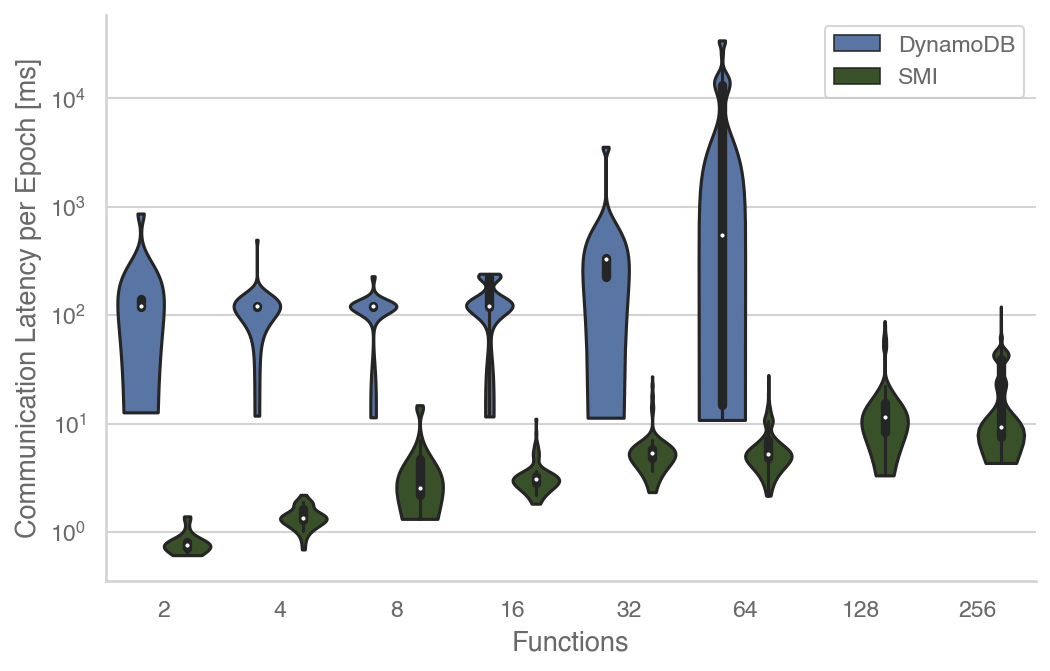

In [ ]:
my_pal = {"DynamoDB": "b", "SMI": "#385723"}
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()
ax.set_yscale('log')
sns.violinplot(x="n", y="latency", hue="method", data=vals, ax=ax, cut=0, palette=my_pal, scale="count")
ax.set_xlabel("Functions")
ax.set_ylabel("Communication Latency per Epoch [ms]")
ax.legend()
fig.savefig(os.path.join(OUTPUT_PATH, "smi_benchmark_lambdaml.pdf"))

### Costs

{2: 0.008965061616195574, 4: 0.01196098604095777, 8: 0.023194766145745914, 16: 0.05316193065642251, 32: 0.35920268552055096, 64: 7.5264374851456015}
{2: 0.013427329888078902, 4: 0.013496359269041486, 8: 0.013956190596445402, 16: 0.014335585074093608, 32: 0.016823077753734587, 64: 0.020624279741369354}


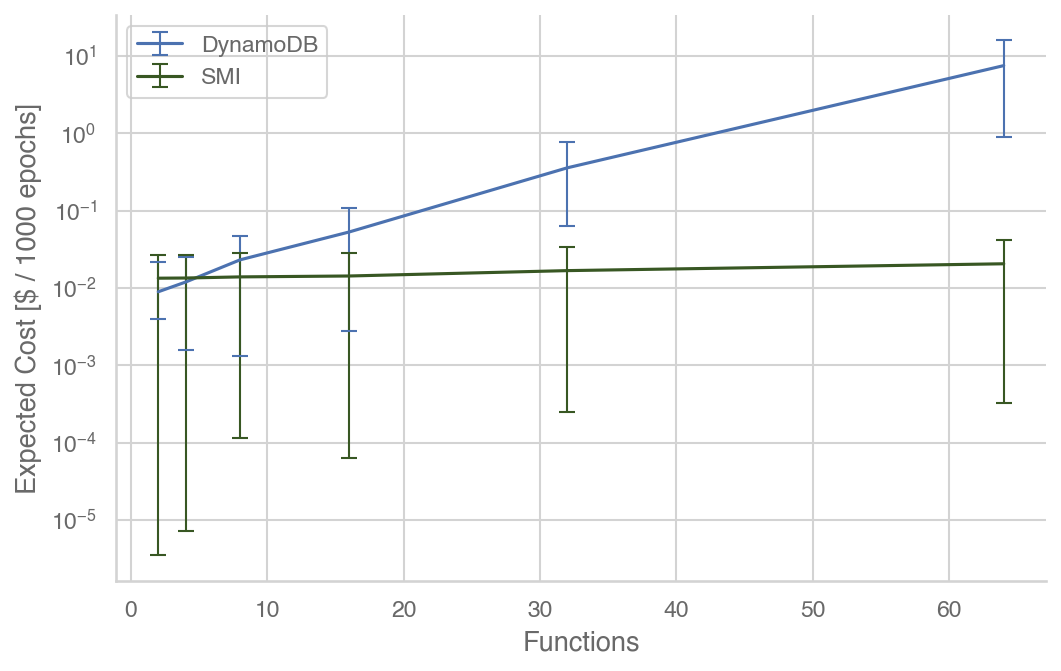

In [ ]:
import scipy.stats as st
ec2_instance_price = 0.0134
gib_second_price = 0.0000166667
dynamodb_rcu_price = 0.0001586
dynamodb_wcu_price = 0.000793

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()
#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Functions")
ax.set_ylabel("Expected Cost [$ / 1000 epochs]")
#ax.set_xticks(list(one_to_many_scalability_means["S3"].keys()))
#ax.set_xticklabels(format_xticks(one_to_many_scalability_means["S3"].keys()))
ddb_lower_error, ddb_upper_error = [], []
ddb_plot_data = {}
smi_lower_error, smi_upper_error = [], []
smi_plot_data = {}
for num_node in NUM_NODES:
    if num_node > 64:
        continue

    dynamodb_data = vals[(vals['n'] == num_node) & (vals['method'] == "DynamoDB")]['latency']
    dynamodb_mean = np.mean(dynamodb_data)
    low, high = st.t.interval(0.95, len(dynamodb_data) - 1, loc=dynamodb_mean, scale=st.sem(dynamodb_data))
    ddb_fixed_cost = num_node * dynamodb_rcu_price + num_node * dynamodb_wcu_price
    ddb_price = dynamodb_mean * num_node * 1000 / 1000 * gib_second_price + ddb_fixed_cost
    low_price = low * num_node * 1000 / 1000 * gib_second_price + ddb_fixed_cost
    high_price = high * num_node * 1000 / 1000 * gib_second_price + ddb_fixed_cost
    ddb_plot_data[num_node] = ddb_price
    ddb_lower_error.append(low_price)
    ddb_upper_error.append(high_price)

    smi_data = vals[(vals['n'] == num_node) & (vals['method'] == "SMI")]['latency']
    smi_mean = np.mean(smi_data)
    low, high = st.t.interval(0.95, len(smi_data) - 1, loc=smi_mean, scale=st.sem(smi_data))
    smi_fixed_cost = ec2_instance_price
    smi_price = smi_mean * num_node * 1000 / 1000 * gib_second_price + smi_fixed_cost
    low_price = low * num_node * 1000 / 1000 * gib_second_price + smi_fixed_cost
    high_price = high * num_node * 1000 / 1000 * gib_second_price + smi_fixed_cost
    smi_plot_data[num_node] = smi_price
    smi_lower_error.append(low_price)
    smi_upper_error.append(high_price)
    
ax.errorbar(ddb_plot_data.keys(), ddb_plot_data.values(), [ddb_lower_error, ddb_upper_error], elinewidth=1, capsize=4, label="DynamoDB", color="b")
ax.errorbar(smi_plot_data.keys(), smi_plot_data.values(), [smi_lower_error, smi_upper_error], elinewidth=1, capsize=4, label="SMI", color="#385723")
print(ddb_plot_data)
print(smi_plot_data)
ax.legend()
fig.savefig(os.path.join(OUTPUT_PATH, "smi_benchmark_lambdaml_costs.pdf"))
plt.show()

0     133.123636
1     287.794590
2      62.372923
3     117.797136
4     122.381687
5     861.270428
6     126.661301
7     138.373137
8     118.355274
18    119.862556
19    227.122307
20    120.813608
21    119.382620
22    119.691849
23    866.039753
24    140.588284
25    119.091272
26     12.675285
Name: latency, dtype: float64